# Task Inference on The Differential Level

## Setup
- We assume that there exists an unknown Lie group G that induces the reward and transition functions of the different tasks
- We have samples from different tasks
- We assume that the level sets of the different tasks are all connected curves (a foliation?)
- We know that the reward and transition function of each task have a Kernel. For now, assume that only reward functions change. Thereby, the different tasks have reward-function Kernels D^1, ..., D^N_tasks
- Thereby, there should exists a Lie group tilde(G) acting on S and A that aligns the different Kernels. This means that for all p in M, there should exist a left-action l_tilde(G) in tilde(G) such that the Kernel of the new task D^2(l_tilde(G)(p)) = D^(p)
    - If such a Lie group tilde(G) exists, we have successfully translated the geometry in m into a geometry in S times A
    - How can we learn such a Lie group?
        - a

## Hard-Code Kernels of Each Task

In [110]:
import warnings
from typing import Tuple, Optional, Callable

from constants import DTYPE, FIG_HEIGHT, LABEL_FONT_SIZE
import torch as th
RANDOM_SEED=41
th.manual_seed(RANDOM_SEED)

def sample_kernel_samples_from_task(task_goal: th.tensor,
                                        p_batch: th.tensor)->th.tensor:
    """Returns kernel samples at batched points p from a task."""

    _generator=th.tensor([[0, -1], [1,0]], dtype=DTYPE, requires_grad=False).unsqueeze(0)
    projected_state = (p_batch-task_goal).unsqueeze(-1)
    return th.matmul(_generator, projected_state).squeeze(-1)

N_SAMPLES=250
STATE_DIM=2
TASK_GOALS = []
N_TASKS=8
for k in range(N_TASKS):
    angle = th.tensor(2 * th.pi * k / 8, dtype=DTYPE)
    TASK_GOALS.append(th.tensor([th.cos(angle), th.sin(angle)], dtype=DTYPE))

## Learn the Push-Forward of each Task

In [2]:
from tqdm import tqdm
def compute_vec_jacobian(f: callable, s: th.tensor)->th.tensor:
    """Compute a vectorized Jacobian of function f over a batch of states s."""
    return th.vmap(th.func.jacrev(f))(s)

def compute_push_forward(F_0:th.tensor,
                         vf_1:callable,
                         vf_2:callable,
                         n_iter:int=20_000,
                         batch_size:int=128,
                         state_dim:int=2
                         )->th.tensor:
    """Computes via gradient-flow a linear push-forward from a vector field vf_1 to another vector field vf_2.
    Args:
    - F_0: torch.tensor of shape (N_states, N_states), initialization of the push-forward
    - vf_1: callable, first vector field, takes in a set of batched points of shape (batch_size, N_states) and returns a set of tangent vectors of shape (batch_size, N_states)
    - vf_2: callable, first vector field, takes in a set of batched points of shape (batch_size, N_states) and returns a set of tangent vectors of shape (batch_size, N_states)
    
    Returns:
    - The linear push-forward if it exists.
    """
    warnings.warn("Only supports linear push-forwards. For non-linear, implement derivative of push-forward.")
    F=th.tensor(F_0.clone(), dtype=DTYPE, requires_grad=True)
    opt_F=th.optim.Adam([F], lr=0.00035)

    pbar = tqdm(range(n_iter), desc="Compute Push-Forward") 
    for idx_step in pbar:
        # Sample points and push-forward points
        ps=th.randn((batch_size, state_dim))
        F_ps=th.einsum("mn,bn->bm",F,ps)

        # Sample tangent vectors and push-forward tangent vectors
        vf_2_F_ps=vf_2(F_ps)
        vf_1_ps=vf_1(ps)
        dF_vf_1_ps=th.einsum("mn,bn->bm",F,vf_1_ps)

        # Compute loss. If F is push-forward, we must have dF_vf_1_ps=vf_2_F_ps
        loss = th.sum(th.norm(dF_vf_1_ps-vf_2_F_ps, dim=1),dim=0)
        
        # Take gradient step
        opt_F.zero_grad()
        loss.backward()
        opt_F.step()
        if idx_step % 100 == 0:
            pbar.set_postfix({'Push-Forward. Loss (optimum=0)': f'{loss:.2f}'})

    return F.round(decimals=3)

In [3]:
# Linear Maps H that map the kernel of task i to the kernel of task 0
F_0_all_tasks=th.tensor(th.randn(size=(STATE_DIM, STATE_DIM)))

# Callables that return a batch of samples from a vector field at a batch of points.
def kernel_fn_of_task(task_goal)->callable:
    """Callable that returns a sample of a vector field at a point."""
    return lambda ps: sample_kernel_samples_from_task(task_goal, p_batch=ps)

vf_tasks = [kernel_fn_of_task(task_goal=task_goal) for task_goal in TASK_GOALS]

# Compute F-Related linear map between Kernels
vf_base_task=vf_tasks[0]
vf_other_tasks=vf_tasks[1:]
lgs_tasks_th = [compute_push_forward(F_0=F_0_all_tasks,
                                     vf_1=vf_base_task,
                                     vf_2=vf_other_task) for vf_other_task in vf_other_tasks]

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_39946/3330981952.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F_0_all_tasks=th.tensor(th.randn(size=(STATE_DIM, STATE_DIM)))
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_39946/3049038105.py:18: UserWarning: Only supports linear push-forwards. For non-linear, implement derivative of push-forward.
  warnings.warn("Only supports linear push-forwards. For non-linear, implement derivative of push-forward.")
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_39946/3049038105.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F=th.tensor(F_0.clone(), dtype=DTYPE, requires_grad=True)
Compute Push-Forward: 1

In [4]:
for idx, lg_task_th in enumerate(lgs_tasks_th):
    print(f"Base Goal Position: {TASK_GOALS[0]}\nTask Goal Position: {TASK_GOALS[idx+1]}\nF-Map: {lg_task_th}\n\n")

Base Goal Position: tensor([1., 0.])
Task Goal Position: tensor([0.7071, 0.7071])
F-Map: tensor([[ 0.7070, -0.7070],
        [ 0.7070,  0.7070]], grad_fn=<RoundBackward1>)


Base Goal Position: tensor([1., 0.])
Task Goal Position: tensor([-4.3711e-08,  1.0000e+00])
F-Map: tensor([[ 0., -1.],
        [ 1., -0.]], grad_fn=<RoundBackward1>)


Base Goal Position: tensor([1., 0.])
Task Goal Position: tensor([-0.7071,  0.7071])
F-Map: tensor([[-0.7070, -0.7070],
        [ 0.7070, -0.7070]], grad_fn=<RoundBackward1>)


Base Goal Position: tensor([1., 0.])
Task Goal Position: tensor([-1.0000e+00, -8.7423e-08])
F-Map: tensor([[-1.,  0.],
        [ 0., -1.]], grad_fn=<RoundBackward1>)


Base Goal Position: tensor([1., 0.])
Task Goal Position: tensor([-0.7071, -0.7071])
F-Map: tensor([[-0.7070,  0.7070],
        [-0.7070, -0.7070]], grad_fn=<RoundBackward1>)


Base Goal Position: tensor([1., 0.])
Task Goal Position: tensor([ 1.1925e-08, -1.0000e+00])
F-Map: tensor([[ 0.,  1.],
        [-1.,  0.]]

## Step 2: Learn Maximal Symmetry

- At this point, we learned left-actions from our unknown group $G$ acting on $S \times A$
    - For each task, we learned one left-action $F_1,...F_{n train}$
    - If these left-actions are indeed linear, we call them $g_1,...,g_{n train}$
- Which Lie group $G$ contains $g_1,...,g_{n train}$?
    - Turns out many, for example $G:=GL(n states)$
- Instead, we can also check whether a Lie group $\hat{G}$ induced by a infinitesimal generator $\hat{W}$ can generate the left-actions $g_1,...,g_{n train}$
    - We know that if $\hat{G}$ is connected, there exists a weight real-valued weight $w$ such that:
        $g_i = exp(w_i W)$
    - Hence, if we apply the matrix-logarithm, we have: $log(g_i)=w_i W$ for some unknown $w_i$
    - This can be easily evaluated by checking whether $log(g_i) \in span(\hat{W}) \forall i=1,...,n train$ 

In [5]:
# Convert left-actions to numpy as torch does not have a matrix logarithm.
# Then compute matrix logarithm of each left-action.
import scipy
import numpy as np
lgs_tasks_np=[lg.detach().numpy() for lg in lgs_tasks_th]
log_lgs_tasks_complex=[scipy.linalg.logm(lg_tasks_np) for lg_tasks_np in lgs_tasks_np]
take_real = lambda num: np.round(np.real(num), 4) if np.all(np.abs(np.imag(num)) < 1e-4) else None
log_lgs_tasks_realb=[take_real(log_lg) for log_lg in log_lgs_tasks_complex]

logm result may be inaccurate, approximate err = 1.4237328349832393e-07
logm result may be inaccurate, approximate err = 1.1337070859873677e-07
logm result may be inaccurate, approximate err = 1.9044607379863199e-07
logm result may be inaccurate, approximate err = 1.9044607379863199e-07
logm result may be inaccurate, approximate err = 1.1337070859873677e-07
logm result may be inaccurate, approximate err = 1.4237328349832393e-07


In [6]:
def project_onto_tensor_subspace(tensors: th.tensor, basis: th.tensor) -> Tuple[th.tensor, th.tensor]:
    """
    Projects 2-tensors onto a d-dimensional subspace of 2-tensors.
    Args:
    - tensors: torch.tensor of shape (b,1,n,n), b two-tensors
    - basis: torch.tensor of shape (1,d,n,n), a d-dimensional vector space of two-tensors, given by its basis.

    Returns: 
    - proj and orthogonal complement
    """
    b, d, _, _ = basis.shape

    # Compute Gram matrix G: (b, d, d)
    G = th.einsum('bdij,bdij->bd', basis, basis)  # Inner products <B_i, B_j>
    G = G.unsqueeze(-1).expand(-1, -1, d)  # (b,d,d)
    G = G * th.eye(d, device=basis.device).unsqueeze(0) + th.einsum('bdi,bdi->bdi', basis.view(b, d, -1), basis.view(b, d, -1)).transpose(1,2)

    G = th.matmul(basis.view(b, d, -1), basis.view(b, d, -1).transpose(1, 2))  # (b, d, d)
    G_inv = th.linalg.pinv(G)  # (b, d, d)

    # Compute b: (b, d)
    v = tensors.expand(-1, d, -1, -1)  # (b, d, n, n)
    b_proj = th.einsum('bdij,bdij->bd', v, basis)  # (b, d)

    # Compute coefficients alpha: (b, d)
    alpha = th.matmul(G_inv, b_proj.unsqueeze(-1)).squeeze(-1)  # (b, d)

    # Reconstruct projection: sum_i alpha_i * basis_i
    proj = th.sum(alpha.unsqueeze(-1).unsqueeze(-1) * basis, dim=1, keepdim=True)  # (b,1,n,n)
    ortho_comp=tensors-proj
    return proj, ortho_comp

In [7]:
# Log-left actions of the different tasks. Tensor of shape (N_tasks, 1, STATE_DIM, STATE_DIM)
log_lgs_th = [th.tensor(log_lg, dtype=DTYPE).reshape((STATE_DIM, STATE_DIM)) if log_lg is not None else th.zeros(size=(STATE_DIM, STATE_DIM)) for log_lg in log_lgs_tasks_realb]
log_lgs_th = th.stack(log_lgs_th).unsqueeze(1)

In [9]:
from tqdm import tqdm
def learn_meta_symmetry(W_0:th.tensor,
                         log_left_actions:th.tensor,
                         n_iter:int=20_000,
                         )->th.tensor:
    """Computes the Differential Generator of a Meta Lie Group G from sampled left-actions.
    Args:
    - W_0: torch.tensor of shape (1,d,N_states, N_states), initialization of the differential generator of G
    - left_actions: torch.tensor of shape (N_tasks, 1, N_states, N_states), log of the sampled left-actions from G     
    Returns:
    - XXX
    """

    warnings.warn("Tested only for one-dimensional Meta-Symmetries.")
    assert len(W_0.shape)==4, "Differential Generator must be of shape (1,d,n_states,n_states)"

    W=th.tensor(W_0.clone(), dtype=DTYPE, requires_grad=True)
    opt_F=th.optim.Adam([W], lr=0.00035)

    pbar = tqdm(range(n_iter), desc="Compute Meta-Symmetry")

    for idx_step in pbar:

        # Project log left actions onto the vector space spanned by W.
        # W_perp is the orthogonal complement of each left-action with respect to W
        _, W_perp=project_onto_tensor_subspace(tensors=log_left_actions, basis=W)
        W_perp_flat=W_perp.squeeze(1) #remove the Lie group dimension (always 1). New shape: (N_tasks, N_states, N_states)

        # Compute loss. If G contains all left-actions, the log-left-actions must be inside the span of W.
        # Each orthogonal complement is a tensor of shape (n_state, n_states). Compute the Frobenius norm of each orthogonal complement
        # and mean across all tasks.
        loss = th.mean(th.norm(W_perp_flat, p="fro",dim=(1,2)),dim=0)
        
        # Take gradient step
        opt_F.zero_grad()
        loss.backward()
        opt_F.step()
        if idx_step % 100 == 0:
            pbar.set_postfix({'Meta-Symmetry. Loss (optimum=0)': f'{loss:.2f}'})

    return W.round(decimals=3)

In [166]:
META_GEOMETRY_DIM=1
rand_action=th.randn(size=(2,1,2,2)) #sanity check, converges to nothing
W_Meta_Sym_0=th.tensor(th.randn(size=(1,META_GEOMETRY_DIM,STATE_DIM, STATE_DIM)))
W_Meta_Sym_star=learn_meta_symmetry(W_0=W_Meta_Sym_0,
                                    # log_left_actions=rand_action,
                                    log_left_actions=log_lgs_th,
                                    n_iter=7_500
                                    )

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_39946/2020522024.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W_Meta_Sym_0=th.tensor(th.randn(size=(1,META_GEOMETRY_DIM,STATE_DIM, STATE_DIM)))
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_39946/695153465.py:14: UserWarning: Tested only for one-dimensional Meta-Symmetries.
  warnings.warn("Tested only for one-dimensional Meta-Symmetries.")
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_39946/695153465.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W=th.tensor(W_0.clone(), dtype=DTYPE, requires_grad=True)
Compute Meta-Symmetry: 100%|██████████| 15000/15000 [00:06<00:00, 2185.45it/s, Meta-Symm

In [167]:
print("Learned Differential Generator of Meta-Symmetry:\n", W_Meta_Sym_star)

Learned Differential Generator of Meta-Symmetry:
 tensor([[[[ 0.0000, -1.3370],
          [ 1.3370, -0.0000]]]], grad_fn=<RoundBackward1>)


## Experiment: What influence does task distribution noise and number of training tasks have?
- Add noise into the task distribution such that the goal locations are not exactly on $S^1$ anymore.
- Then, compute a hereditary geometry and compare how the span of the hereditary geometry aligns with the span of the ground-truth geometry.

In [243]:
def compute_symmetry_loss(n_tasks: int, sigma_noise: float)-> float:
    """Computes a Meta-Symmetry G from the kernels of n_tasks where the goal location is corrupted by sigma_noise.
    Returns:
    learned_generator: tensor, the generator we learned of the geometry G
    loss_max: float, is the ground-truth generator a subset of the learned generator?
    loss_min: float, is the learned generator a subset of the ground-truth generator (showing that we converge to symmetries that are too large)
    """
    task_angles=th.rand(size=(n_tasks,))*2*th.pi
    task_locations = th.stack((th.cos(task_angles), th.sin(task_angles)), dim=1)
    random_displacement=th.randn_like(task_locations) * sigma_noise
    task_locations+=random_displacement

    # Step 2: Compute left-action of each task.
    F_0_all_tasks=th.tensor(th.randn(size=(STATE_DIM, STATE_DIM)))
    vf_base_task=vf_tasks[0]
    vf_tasks_noise = [kernel_fn_of_task(task_goal=task_goal) for task_goal in task_locations]
    lgs_tasks_noise_th = [compute_push_forward(F_0=F_0_all_tasks,
                                        vf_1=vf_base_task,
                                        vf_2=vf_other_task) for vf_other_task in vf_tasks_noise]

    # Step 3: Convert left-actions to log-space.
    lgs_tasks_noise_np=[lg.detach().numpy() for lg in lgs_tasks_noise_th]
    log_lgs_tasks_noise_complex=[scipy.linalg.logm(lg_tasks_np) for lg_tasks_np in lgs_tasks_noise_np]
    log_lgs_tasks_noise_real=[take_real(log_lg) for log_lg in log_lgs_tasks_noise_complex]

    # Step 3b: Back to Torch
    log_lgs_noise_th = [th.tensor(log_lg, dtype=DTYPE).reshape((STATE_DIM, STATE_DIM)) if log_lg is not None else th.zeros(size=(STATE_DIM, STATE_DIM)) for log_lg in log_lgs_tasks_noise_real]
    log_lgs_noise_th = th.stack(log_lgs_noise_th).unsqueeze(1)

    # Step 4: Learn Meta-Symmetry G
    META_GEOMETRY_DIM=1
    W_Meta_Sym_0=th.tensor(th.randn(size=(1,META_GEOMETRY_DIM,STATE_DIM, STATE_DIM)))
    W_Meta_Sym_star_noisy_tasks=learn_meta_symmetry(W_0=W_Meta_Sym_0,
                                        # log_left_actions=rand_action,
                                        log_left_actions=log_lgs_noise_th,
                                        n_iter=7_500
                                        )

    # Step 5: Compare With Ground-Truth G. Here, we want to know whether the learned symmetry contains the 
    W_ORACLE=th.tensor([[0, -1], [1,0]], dtype=DTYPE).unsqueeze(0).unsqueeze(0)
    _, ortho_comp_max=project_onto_tensor_subspace(tensors=W_ORACLE, basis=W_Meta_Sym_star_noisy_tasks)
    _, ortho_comp_min=project_onto_tensor_subspace(tensors=W_Meta_Sym_star_noisy_tasks, basis=W_ORACLE)
    loss_max=th.norm(ortho_comp_max.squeeze(1).squeeze(1), p="fro") #Does the learned generator contain the ground-truth geometry?
    loss_min=th.norm(ortho_comp_min.squeeze(1).squeeze(1), p="fro") #Is the learned generator larger than the ground-truth geometry?
    return W_Meta_Sym_star_noisy_tasks, loss_max, loss_min
    

In [278]:
# Step 1: Sample tasks (goal location slightly corrupted by noise).
N_TASK_VALUES = [1, 2, 3, 4, 5, 6, 7, 8]
SIGMA_NOISES = [0.01, 0.3, 0.6, 0.9]
N_RUNS_PER_CONFIG=5

all_losses_max = []
all_losses_min = []
learned_gens = []

for n_tasks in N_TASK_VALUES:
    for sigma_noise in SIGMA_NOISES:
        print(f"N tasks: {n_tasks}, sigma noise: {sigma_noise}\n\n")
        loss_min=0
        loss_max=0

        for run in range(N_RUNS_PER_CONFIG):
            _, loss_max_run, loss_min_run = compute_symmetry_loss(n_tasks, sigma_noise)
            loss_min+=loss_min_run
            loss_max+=loss_max_run

        all_losses_max.append((n_tasks, sigma_noise, loss_max/N_RUNS_PER_CONFIG))
        all_losses_min.append((n_tasks, sigma_noise, loss_min/N_RUNS_PER_CONFIG))


/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_39946/4226721805.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F_0_all_tasks=th.tensor(th.randn(size=(STATE_DIM, STATE_DIM)))
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_39946/3049038105.py:18: UserWarning: Only supports linear push-forwards. For non-linear, implement derivative of push-forward.
  warnings.warn("Only supports linear push-forwards. For non-linear, implement derivative of push-forward.")
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_39946/3049038105.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  F=th.tensor(F_0.clone(), dtype=DTYPE, requires_grad=True)


N tasks: 1, sigma noise: 0.01




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3297.20it/s, Push-Forward. Loss (optimum=0)=0.03] 
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_39946/4226721805.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W_Meta_Sym_0=th.tensor(th.randn(size=(1,META_GEOMETRY_DIM,STATE_DIM, STATE_DIM)))
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_39946/695153465.py:14: UserWarning: Tested only for one-dimensional Meta-Symmetries.
  warnings.warn("Tested only for one-dimensional Meta-Symmetries.")
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_39946/695153465.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W=th.tensor(W_0.clone(), dtyp

logm result may be inaccurate, approximate err = 2.0683934993226597e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3297.90it/s, Push-Forward. Loss (optimum=0)=0.00] 


logm result may be inaccurate, approximate err = 1.2332800066587645e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:05<00:00, 3355.74it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.4064315218443657e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3201.29it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.7093026384240088e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:05<00:00, 3418.54it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 8.566311350027935e-08


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2464.51it/s, Meta-Symmetry. Loss (optimum=0)=0.00]


N tasks: 1, sigma noise: 0.3




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3168.15it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 1.70274160100141e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:05<00:00, 3366.71it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 2.3669474943287656e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3184.44it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.2212024806471955e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3327.48it/s, Push-Forward. Loss (optimum=0)=0.03] 


logm result may be inaccurate, approximate err = 1.7155402419594954e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3136.82it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 9.309815011740288e-08


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2393.45it/s, Meta-Symmetry. Loss (optimum=0)=0.00]


N tasks: 1, sigma noise: 0.6




Compute Push-Forward: 100%|██████████| 20000/20000 [00:05<00:00, 3375.78it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 1.8406487911669233e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3222.87it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 1.928756525445717e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3221.47it/s, Push-Forward. Loss (optimum=0)=0.01]


logm result may be inaccurate, approximate err = 1.355609071701563e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3296.01it/s, Push-Forward. Loss (optimum=0)=0.00] 


logm result may be inaccurate, approximate err = 5.236364180159146e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3203.80it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 3.0258126874298437e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2423.39it/s, Meta-Symmetry. Loss (optimum=0)=0.00]


N tasks: 1, sigma noise: 0.9




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3277.07it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 2.1168859932406305e-08


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3217.42it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 1.8722696154823096e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3327.66it/s, Push-Forward. Loss (optimum=0)=0.02]  


logm result may be inaccurate, approximate err = 3.682834682897887e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3304.26it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 1.5791346711951833e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3325.47it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.491320148703411e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2436.57it/s, Meta-Symmetry. Loss (optimum=0)=0.00]


N tasks: 2, sigma noise: 0.01




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3300.70it/s, Push-Forward. Loss (optimum=0)=0.03] 


logm result may be inaccurate, approximate err = 2.5331297514186365e-07
logm result may be inaccurate, approximate err = 1.5418754229078602e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3279.75it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 1.8452755921591747e-07
logm result may be inaccurate, approximate err = 1.3718176620594123e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3322.75it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.845873218448685e-07
logm result may be inaccurate, approximate err = 2.238987207948936e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3289.47it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.9860986570935003e-07
logm result may be inaccurate, approximate err = 7.052511273093488e-08


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3304.50it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 3.5631424990980137e-07
logm result may be inaccurate, approximate err = 7.856357481631414e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2348.07it/s, Meta-Symmetry. Loss (optimum=0)=0.00]


N tasks: 2, sigma noise: 0.3




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3281.42it/s, Push-Forward. Loss (optimum=0)=0.00]  


logm result may be inaccurate, approximate err = 3.6249311528640146e-07
logm result may be inaccurate, approximate err = 1.7814730423755437e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3256.82it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 6.738874255757311e-08
logm result may be inaccurate, approximate err = 2.3259128869095888e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3305.44it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 4.459477085322808e-07
logm result may be inaccurate, approximate err = 1.442298457614116e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3274.25it/s, Push-Forward. Loss (optimum=0)=0.03] 


logm result may be inaccurate, approximate err = 2.2722481173015315e-07
logm result may be inaccurate, approximate err = 1.803642030141706e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3250.98it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 9.105821661607796e-08
logm result may be inaccurate, approximate err = 1.3953653582589555e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2346.12it/s, Meta-Symmetry. Loss (optimum=0)=0.00]


N tasks: 2, sigma noise: 0.6




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3254.04it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 4.933137791327474e-07
logm result may be inaccurate, approximate err = 4.658307293484122e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3258.49it/s, Push-Forward. Loss (optimum=0)=0.00] 


logm result may be inaccurate, approximate err = 2.07074091404612e-07
logm result may be inaccurate, approximate err = 3.5063804619396496e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3250.64it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 3.28532934378034e-07
logm result may be inaccurate, approximate err = 2.61048565879542e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3278.49it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 3.0958848701978015e-07
logm result may be inaccurate, approximate err = 1.7817560743359272e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3195.07it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.1509021551319904e-07
logm result may be inaccurate, approximate err = 1.8813664958152717e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2282.06it/s, Meta-Symmetry. Loss (optimum=0)=0.43]


N tasks: 2, sigma noise: 0.9




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3241.09it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.0381100672579585e-07
logm result may be inaccurate, approximate err = 7.859901048071478e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3199.41it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 5.354058656708249e-07
logm result may be inaccurate, approximate err = 9.137778986318881e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3273.01it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 1.7899749024539312e-07
logm result may be inaccurate, approximate err = 8.26373956104007e-08


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3176.65it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 4.912335667587032e-07
logm result may be inaccurate, approximate err = 2.884843932961455e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3256.05it/s, Push-Forward. Loss (optimum=0)=0.00] 


logm result may be inaccurate, approximate err = 4.817067419368944e-07
logm result may be inaccurate, approximate err = 1.9751047601336698e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2296.04it/s, Meta-Symmetry. Loss (optimum=0)=0.73]


N tasks: 3, sigma noise: 0.01




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3228.41it/s, Push-Forward. Loss (optimum=0)=0.03] 


logm result may be inaccurate, approximate err = 5.287314036391574e-08
logm result may be inaccurate, approximate err = 2.518031240513857e-07
logm result may be inaccurate, approximate err = 2.1475024023853052e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3162.47it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 1.5657651429571947e-07
logm result may be inaccurate, approximate err = 1.3552885306154326e-07
logm result may be inaccurate, approximate err = 2.39181172446975e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3257.34it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 3.3417839044313876e-07
logm result may be inaccurate, approximate err = 2.551803987105342e-07
logm result may be inaccurate, approximate err = 2.4228480365031444e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3258.60it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.1727440043063893e-07
logm result may be inaccurate, approximate err = 1.6988664472260065e-07
logm result may be inaccurate, approximate err = 1.305959599207261e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3263.17it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.5603897768532896e-07
logm result may be inaccurate, approximate err = 1.7481312658647095e-07
logm result may be inaccurate, approximate err = 1.3974492339510185e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2276.48it/s, Meta-Symmetry. Loss (optimum=0)=0.00]


N tasks: 3, sigma noise: 0.3




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3143.29it/s, Push-Forward. Loss (optimum=0)=0.02]


logm result may be inaccurate, approximate err = 2.1964150053865558e-07
logm result may be inaccurate, approximate err = 1.1854716605103248e-07
logm result may be inaccurate, approximate err = 1.6154613078773138e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3179.52it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.615004147644091e-07
logm result may be inaccurate, approximate err = 1.5603956630156086e-07
logm result may be inaccurate, approximate err = 3.970809589905851e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3170.35it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.5654890202613017e-07
logm result may be inaccurate, approximate err = 1.41348431592127e-07
logm result may be inaccurate, approximate err = 1.9385397670216551e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3225.24it/s, Push-Forward. Loss (optimum=0)=0.00] 


logm result may be inaccurate, approximate err = 1.2621410989406084e-07
logm result may be inaccurate, approximate err = 2.7565138671748964e-07
logm result may be inaccurate, approximate err = 2.111086830460213e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3241.13it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 4.257012760833064e-08
logm result may be inaccurate, approximate err = 1.397426823686304e-07
logm result may be inaccurate, approximate err = 9.818469351706398e-08


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2314.37it/s, Meta-Symmetry. Loss (optimum=0)=0.04]


N tasks: 3, sigma noise: 0.6




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3238.88it/s, Push-Forward. Loss (optimum=0)=0.03]


logm result may be inaccurate, approximate err = 1.3241628827903092e-07
logm result may be inaccurate, approximate err = 3.6729043466930276e-07
logm result may be inaccurate, approximate err = 1.9597193132726501e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3158.08it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 4.4948676107551356e-07
logm result may be inaccurate, approximate err = 5.798720187536286e-07
logm result may be inaccurate, approximate err = 1.547781953616254e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3234.96it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.488179832753835e-07
logm result may be inaccurate, approximate err = 1.461903605949287e-07
logm result may be inaccurate, approximate err = 8.963303678780775e-08


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3165.20it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 2.2841523063672114e-07
logm result may be inaccurate, approximate err = 1.0624950754716904e-07
logm result may be inaccurate, approximate err = 1.284498291162224e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3144.75it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.5632565989937296e-07
logm result may be inaccurate, approximate err = 2.771747156611923e-07
logm result may be inaccurate, approximate err = 1.8136266398045128e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2258.59it/s, Meta-Symmetry. Loss (optimum=0)=0.11]


N tasks: 3, sigma noise: 0.9




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3144.92it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 1.988677343554934e-07
logm result may be inaccurate, approximate err = 6.046756276432866e-08
logm result may be inaccurate, approximate err = 1.40523515444763e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3209.49it/s, Push-Forward. Loss (optimum=0)=0.00] 


logm result may be inaccurate, approximate err = 1.249234888181451e-07
logm result may be inaccurate, approximate err = 1.1563890018156526e-07
logm result may be inaccurate, approximate err = 2.255393960933523e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3230.57it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 1.4526138823287858e-07
logm result may be inaccurate, approximate err = 2.4057361106713404e-07
logm result may be inaccurate, approximate err = 4.333436613037878e-08


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3249.60it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 1.7620211439295928e-07
logm result may be inaccurate, approximate err = 2.800054263821366e-07
logm result may be inaccurate, approximate err = 2.351028256626618e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3264.54it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.4329164466545226e-07
logm result may be inaccurate, approximate err = 3.0996220323235236e-08
logm result may be inaccurate, approximate err = 1.6260448206123415e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2263.12it/s, Meta-Symmetry. Loss (optimum=0)=0.57]


N tasks: 4, sigma noise: 0.01




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3236.16it/s, Push-Forward. Loss (optimum=0)=0.00] 


logm result may be inaccurate, approximate err = 2.0275065469006623e-07
logm result may be inaccurate, approximate err = 1.2600133234974647e-07
logm result may be inaccurate, approximate err = 1.3332239552601303e-07
logm result may be inaccurate, approximate err = 2.877541800379106e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3255.05it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 3.9561120924325275e-07
logm result may be inaccurate, approximate err = 2.5995240773048777e-07
logm result may be inaccurate, approximate err = 5.626172577983401e-07
logm result may be inaccurate, approximate err = 2.1125826009402252e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3255.40it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 4.478223253167433e-07
logm result may be inaccurate, approximate err = 1.768574216275289e-07
logm result may be inaccurate, approximate err = 2.4719757190864974e-07
logm result may be inaccurate, approximate err = 1.7413934414657127e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [01:06<00:00, 300.77it/s, Push-Forward. Loss (optimum=0)=0.04]  


logm result may be inaccurate, approximate err = 1.7000921322955167e-07
logm result may be inaccurate, approximate err = 1.707433655779027e-07
logm result may be inaccurate, approximate err = 1.4044487817042662e-07
logm result may be inaccurate, approximate err = 1.5753467595467696e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3247.87it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.569485523896518e-07
logm result may be inaccurate, approximate err = 1.9544364112086107e-07
logm result may be inaccurate, approximate err = 1.901853302875394e-07
logm result may be inaccurate, approximate err = 2.291261343433404e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2198.95it/s, Meta-Symmetry. Loss (optimum=0)=0.02]


N tasks: 4, sigma noise: 0.3




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3239.79it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 9.943172370435215e-08
logm result may be inaccurate, approximate err = 2.446504175310232e-07
logm result may be inaccurate, approximate err = 2.65956051721921e-07
logm result may be inaccurate, approximate err = 1.2699355443097336e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3187.33it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.1152681651155097e-07
logm result may be inaccurate, approximate err = 2.6715755798754073e-07
logm result may be inaccurate, approximate err = 2.1510453637845877e-07
logm result may be inaccurate, approximate err = 3.905967598686054e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3206.13it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 6.168946631300451e-07
logm result may be inaccurate, approximate err = 1.346982392332687e-07
logm result may be inaccurate, approximate err = 1.1016763457721336e-07
logm result may be inaccurate, approximate err = 1.7466257291419394e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3252.44it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.739019658553274e-07
logm result may be inaccurate, approximate err = 4.880138143278569e-07
logm result may be inaccurate, approximate err = 3.9076983357151e-07
logm result may be inaccurate, approximate err = 5.033538483659879e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3212.56it/s, Push-Forward. Loss (optimum=0)=0.00] 


logm result may be inaccurate, approximate err = 2.418156034187745e-07
logm result may be inaccurate, approximate err = 2.388094277915197e-07
logm result may be inaccurate, approximate err = 3.460522888806536e-07
logm result may be inaccurate, approximate err = 7.017664350325996e-08


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2250.70it/s, Meta-Symmetry. Loss (optimum=0)=0.18]


N tasks: 4, sigma noise: 0.6




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 2989.38it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.7252380488503184e-07
logm result may be inaccurate, approximate err = 1.3323994572586272e-07
logm result may be inaccurate, approximate err = 1.1991015771338188e-07
logm result may be inaccurate, approximate err = 1.4830729706561435e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3231.29it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.4274402637199078e-07
logm result may be inaccurate, approximate err = 4.573938955889884e-07
logm result may be inaccurate, approximate err = 2.6865094830736513e-07
logm result may be inaccurate, approximate err = 1.5043559406864e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3220.28it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.5423432377180796e-07
logm result may be inaccurate, approximate err = 3.9821001527509356e-07
logm result may be inaccurate, approximate err = 1.2806019782669986e-07
logm result may be inaccurate, approximate err = 1.812501556185301e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3231.44it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 9.997003587405198e-08
logm result may be inaccurate, approximate err = 4.2648242368708946e-07
logm result may be inaccurate, approximate err = 1.9683777453511426e-07
logm result may be inaccurate, approximate err = 2.3271913191650061e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3078.73it/s, Push-Forward. Loss (optimum=0)=0.00] 


logm result may be inaccurate, approximate err = 2.859779029369513e-07
logm result may be inaccurate, approximate err = 1.707715086883543e-07
logm result may be inaccurate, approximate err = 1.1732926959052259e-07
logm result may be inaccurate, approximate err = 1.3706223692375216e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2234.74it/s, Meta-Symmetry. Loss (optimum=0)=0.62]


N tasks: 4, sigma noise: 0.9




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3111.68it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.683289601736314e-07
logm result may be inaccurate, approximate err = 6.35446551778874e-08
logm result may be inaccurate, approximate err = 2.871857222097024e-07
logm result may be inaccurate, approximate err = 6.299150407165765e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3157.68it/s, Push-Forward. Loss (optimum=0)=0.03]  


logm result may be inaccurate, approximate err = 5.690368547324668e-07
logm result may be inaccurate, approximate err = 1.9189870781815372e-07
logm result may be inaccurate, approximate err = 3.764657061639418e-07
logm result may be inaccurate, approximate err = 3.6705409542200375e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3188.51it/s, Push-Forward. Loss (optimum=0)=0.03] 


logm result may be inaccurate, approximate err = 9.818290479552768e-08
logm result may be inaccurate, approximate err = 1.441155536387805e-07
logm result may be inaccurate, approximate err = 1.8108512556771643e-07
logm result may be inaccurate, approximate err = 3.4346782268215124e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3188.22it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.658782166877199e-07
logm result may be inaccurate, approximate err = 2.941941565503149e-07
logm result may be inaccurate, approximate err = 1.9861801481319312e-07
logm result may be inaccurate, approximate err = 1.5884336573141916e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3089.81it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 7.049838218820069e-08
logm result may be inaccurate, approximate err = 2.673490879640254e-07
logm result may be inaccurate, approximate err = 1.810128364565596e-07
logm result may be inaccurate, approximate err = 6.749397051077758e-08


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2101.95it/s, Meta-Symmetry. Loss (optimum=0)=0.33]


N tasks: 5, sigma noise: 0.01




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3193.41it/s, Push-Forward. Loss (optimum=0)=0.03] 


logm result may be inaccurate, approximate err = 8.809482043476733e-08
logm result may be inaccurate, approximate err = 2.128620535047142e-07
logm result may be inaccurate, approximate err = 2.024239161543787e-07
logm result may be inaccurate, approximate err = 1.1004571903409935e-07
logm result may be inaccurate, approximate err = 2.252729548339508e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3201.07it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.265290855218216e-07
logm result may be inaccurate, approximate err = 7.033806445335574e-08
logm result may be inaccurate, approximate err = 2.4233322780627603e-07
logm result may be inaccurate, approximate err = 3.6869415637763306e-07
logm result may be inaccurate, approximate err = 1.9814333934831243e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3040.98it/s, Push-Forward. Loss (optimum=0)=0.00] 


logm result may be inaccurate, approximate err = 1.925037938680113e-07
logm result may be inaccurate, approximate err = 3.0660117212652186e-07
logm result may be inaccurate, approximate err = 1.7329593743518817e-07
logm result may be inaccurate, approximate err = 1.1344688296943962e-07
logm result may be inaccurate, approximate err = 2.038739323019133e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3216.70it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.2576507471623392e-07
logm result may be inaccurate, approximate err = 6.744152320192442e-08
logm result may be inaccurate, approximate err = 1.1460900740156175e-07
logm result may be inaccurate, approximate err = 1.346461395326153e-07
logm result may be inaccurate, approximate err = 7.390129565217731e-08


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3196.19it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 3.466151250565779e-07
logm result may be inaccurate, approximate err = 3.558647143770927e-07
logm result may be inaccurate, approximate err = 1.8456669648067108e-07
logm result may be inaccurate, approximate err = 1.3503650249454528e-07
logm result may be inaccurate, approximate err = 3.133111284280562e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2194.02it/s, Meta-Symmetry. Loss (optimum=0)=0.00]


N tasks: 5, sigma noise: 0.3




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3133.55it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.7723777602744212e-07
logm result may be inaccurate, approximate err = 2.2541171792372695e-08
logm result may be inaccurate, approximate err = 7.899068455926699e-08
logm result may be inaccurate, approximate err = 6.871459067923577e-07
logm result may be inaccurate, approximate err = 2.2256033074857787e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3231.10it/s, Push-Forward. Loss (optimum=0)=0.00]


logm result may be inaccurate, approximate err = 2.973127116759291e-07
logm result may be inaccurate, approximate err = 1.6358178313321078e-07
logm result may be inaccurate, approximate err = 3.7269193005000845e-07
logm result may be inaccurate, approximate err = 2.335933776359858e-07
logm result may be inaccurate, approximate err = 4.7534335173662956e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3152.31it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.63041646905172e-07
logm result may be inaccurate, approximate err = 1.2904333950514367e-07
logm result may be inaccurate, approximate err = 2.995360771262384e-07
logm result may be inaccurate, approximate err = 3.7540431339505936e-07
logm result may be inaccurate, approximate err = 3.956657421341826e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3240.43it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 7.550572399514991e-08
logm result may be inaccurate, approximate err = 1.976759178651063e-07
logm result may be inaccurate, approximate err = 1.8921308437759506e-07
logm result may be inaccurate, approximate err = 1.2081327687535596e-07
logm result may be inaccurate, approximate err = 1.5679986661790158e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3045.14it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 1.0184684290512512e-07
logm result may be inaccurate, approximate err = 1.206078328673583e-07
logm result may be inaccurate, approximate err = 1.2602775274209324e-07
logm result may be inaccurate, approximate err = 6.576623067721556e-07
logm result may be inaccurate, approximate err = 3.3173667025981875e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2229.92it/s, Meta-Symmetry. Loss (optimum=0)=0.26]


N tasks: 5, sigma noise: 0.6




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3118.30it/s, Push-Forward. Loss (optimum=0)=0.02]


logm result may be inaccurate, approximate err = 2.078493425418346e-07
logm result may be inaccurate, approximate err = 2.0686361189325716e-07
logm result may be inaccurate, approximate err = 1.5910592953635736e-07
logm result may be inaccurate, approximate err = 1.0593222065293634e-07
logm result may be inaccurate, approximate err = 8.900387213595251e-08


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3219.81it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 9.486666600236804e-08
logm result may be inaccurate, approximate err = 1.9623208646489504e-07
logm result may be inaccurate, approximate err = 1.1792939668495423e-07
logm result may be inaccurate, approximate err = 9.738880884901174e-08
logm result may be inaccurate, approximate err = 3.1243420833148186e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3022.80it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 3.960648436938266e-07
logm result may be inaccurate, approximate err = 2.248105636678587e-07
logm result may be inaccurate, approximate err = 9.206422096656404e-08
logm result may be inaccurate, approximate err = 1.5189269060232657e-07
logm result may be inaccurate, approximate err = 6.834745325363287e-08


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3217.06it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.196457453882518e-07
logm result may be inaccurate, approximate err = 1.7544839681741875e-07
logm result may be inaccurate, approximate err = 2.1055226980231126e-07
logm result may be inaccurate, approximate err = 1.1531255015054153e-07
logm result may be inaccurate, approximate err = 1.0541825891987624e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3001.40it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 1.0844224834906029e-07
logm result may be inaccurate, approximate err = 3.2671242029525465e-07
logm result may be inaccurate, approximate err = 2.0513522802626077e-07
logm result may be inaccurate, approximate err = 1.6751562971386627e-07
logm result may be inaccurate, approximate err = 3.032360097256712e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2219.86it/s, Meta-Symmetry. Loss (optimum=0)=0.53]


N tasks: 5, sigma noise: 0.9




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3052.09it/s, Push-Forward. Loss (optimum=0)=0.03] 


logm result may be inaccurate, approximate err = 9.170082057822792e-08
logm result may be inaccurate, approximate err = 2.091863519884837e-07
logm result may be inaccurate, approximate err = 1.5869082545979098e-07
logm result may be inaccurate, approximate err = 2.137910780943727e-07
logm result may be inaccurate, approximate err = 2.838836909587321e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3104.79it/s, Push-Forward. Loss (optimum=0)=0.03] 


logm result may be inaccurate, approximate err = 1.0026863996240087e-07
logm result may be inaccurate, approximate err = 3.2031631939218874e-07
logm result may be inaccurate, approximate err = 2.084271502375132e-07
logm result may be inaccurate, approximate err = 3.382894573168893e-07
logm result may be inaccurate, approximate err = 1.1860907701322389e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3128.76it/s, Push-Forward. Loss (optimum=0)=0.00] 


logm result may be inaccurate, approximate err = 2.8296394464523937e-07
logm result may be inaccurate, approximate err = 5.198491002082391e-07
logm result may be inaccurate, approximate err = 1.5724682062657707e-07
logm result may be inaccurate, approximate err = 1.6448929877964264e-07
logm result may be inaccurate, approximate err = 1.5848640820098528e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3134.09it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 4.1353394297407807e-07
logm result may be inaccurate, approximate err = 7.145790662900478e-08
logm result may be inaccurate, approximate err = 1.9392763810956945e-07
logm result may be inaccurate, approximate err = 2.1334778875082952e-07
logm result may be inaccurate, approximate err = 1.7822571939938565e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3176.40it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 3.465356203833559e-07
logm result may be inaccurate, approximate err = 1.2176597774820448e-07
logm result may be inaccurate, approximate err = 9.13754744921929e-09
logm result may be inaccurate, approximate err = 3.37448225229805e-07
logm result may be inaccurate, approximate err = 2.4168900151845126e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2255.51it/s, Meta-Symmetry. Loss (optimum=0)=0.35]


N tasks: 6, sigma noise: 0.01




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3123.03it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 3.8379905637094807e-07
logm result may be inaccurate, approximate err = 1.9906025008167858e-07
logm result may be inaccurate, approximate err = 1.8930417799763693e-07
logm result may be inaccurate, approximate err = 1.7256899204179476e-07
logm result may be inaccurate, approximate err = 2.7176963181890334e-07
logm result may be inaccurate, approximate err = 8.379059463437026e-08


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3199.72it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.8782174432587525e-07
logm result may be inaccurate, approximate err = 1.7376648981356972e-07
logm result may be inaccurate, approximate err = 2.6098980887699536e-07
logm result may be inaccurate, approximate err = 3.703311160987738e-08
logm result may be inaccurate, approximate err = 1.7817650236473261e-07
logm result may be inaccurate, approximate err = 3.781391549404492e-08


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3177.51it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 1.855720479176281e-07
logm result may be inaccurate, approximate err = 6.730583320899681e-08
logm result may be inaccurate, approximate err = 1.5134069489701245e-07
logm result may be inaccurate, approximate err = 1.6596545460169345e-07
logm result may be inaccurate, approximate err = 1.991768494144966e-07
logm result may be inaccurate, approximate err = 6.652210522084342e-08


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3197.28it/s, Push-Forward. Loss (optimum=0)=0.01]


logm result may be inaccurate, approximate err = 3.1268664976836063e-07
logm result may be inaccurate, approximate err = 1.72734322588037e-07
logm result may be inaccurate, approximate err = 1.6297563439032338e-07
logm result may be inaccurate, approximate err = 3.3048644345741717e-07
logm result may be inaccurate, approximate err = 4.5030401001626265e-07
logm result may be inaccurate, approximate err = 4.589573216990465e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3194.32it/s, Push-Forward. Loss (optimum=0)=0.00] 


logm result may be inaccurate, approximate err = 2.181338909937798e-07
logm result may be inaccurate, approximate err = 9.545400653656595e-08
logm result may be inaccurate, approximate err = 1.8624556272888994e-07
logm result may be inaccurate, approximate err = 1.1830320540226297e-07
logm result may be inaccurate, approximate err = 1.8857728604285763e-07
logm result may be inaccurate, approximate err = 2.003136135427095e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2242.69it/s, Meta-Symmetry. Loss (optimum=0)=0.01]


N tasks: 6, sigma noise: 0.3




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3200.05it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.427906037088454e-07
logm result may be inaccurate, approximate err = 1.0518961405737308e-07
logm result may be inaccurate, approximate err = 8.06481959791491e-08
logm result may be inaccurate, approximate err = 1.337052896514546e-07
logm result may be inaccurate, approximate err = 1.8241725136167806e-07
logm result may be inaccurate, approximate err = 1.8637431640252295e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3039.90it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 2.114876701115926e-07
logm result may be inaccurate, approximate err = 1.491192806940659e-07
logm result may be inaccurate, approximate err = 1.022533737647373e-07
logm result may be inaccurate, approximate err = 1.2438604249078842e-07
logm result may be inaccurate, approximate err = 1.9883838559594005e-07
logm result may be inaccurate, approximate err = 1.9206446391107624e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3194.17it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.7549031308451247e-08
logm result may be inaccurate, approximate err = 2.88401235863358e-07
logm result may be inaccurate, approximate err = 2.8951117457461336e-07
logm result may be inaccurate, approximate err = 5.247475774244168e-07
logm result may be inaccurate, approximate err = 6.247995997102204e-08
logm result may be inaccurate, approximate err = 1.7418339684163105e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3193.05it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 9.356180798303596e-08
logm result may be inaccurate, approximate err = 2.9679053850396374e-07
logm result may be inaccurate, approximate err = 1.0545477589555178e-07
logm result may be inaccurate, approximate err = 1.8474026235623503e-07
logm result may be inaccurate, approximate err = 3.8608694187802425e-07
logm result may be inaccurate, approximate err = 1.659102925215977e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3136.82it/s, Push-Forward. Loss (optimum=0)=0.04] 


logm result may be inaccurate, approximate err = 2.78696132851394e-07
logm result may be inaccurate, approximate err = 1.787923811206769e-07
logm result may be inaccurate, approximate err = 2.194573946384713e-07
logm result may be inaccurate, approximate err = 3.8289273307770164e-07
logm result may be inaccurate, approximate err = 6.022133782155953e-07
logm result may be inaccurate, approximate err = 2.8787037439502867e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2251.24it/s, Meta-Symmetry. Loss (optimum=0)=0.22]


N tasks: 6, sigma noise: 0.6




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3193.83it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 2.003750021541401e-07
logm result may be inaccurate, approximate err = 4.6650437318278826e-07
logm result may be inaccurate, approximate err = 2.926774248049352e-07
logm result may be inaccurate, approximate err = 4.5326303924347373e-07
logm result may be inaccurate, approximate err = 2.475037476775055e-07
logm result may be inaccurate, approximate err = 1.7781162320491774e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3160.59it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.4242696092552124e-07
logm result may be inaccurate, approximate err = 9.093011171329319e-09
logm result may be inaccurate, approximate err = 1.0534904632057576e-07
logm result may be inaccurate, approximate err = 1.2317371248882142e-07
logm result may be inaccurate, approximate err = 1.6032847365723478e-07
logm result may be inaccurate, approximate err = 2.675794364383345e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3122.18it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.4440582081437558e-07
logm result may be inaccurate, approximate err = 1.3977298242525875e-07
logm result may be inaccurate, approximate err = 1.7142959191254517e-07
logm result may be inaccurate, approximate err = 1.534176664608812e-07
logm result may be inaccurate, approximate err = 3.765055551547524e-07
logm result may be inaccurate, approximate err = 1.3232800612982902e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:07<00:00, 2823.99it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.5085919136219697e-07
logm result may be inaccurate, approximate err = 4.6280644344285854e-07
logm result may be inaccurate, approximate err = 2.281841737079501e-07
logm result may be inaccurate, approximate err = 9.20261224731118e-08
logm result may be inaccurate, approximate err = 1.5230756316022827e-07
logm result may be inaccurate, approximate err = 1.7513695265932817e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 2979.20it/s, Push-Forward. Loss (optimum=0)=0.03] 


logm result may be inaccurate, approximate err = 2.770678981213093e-07
logm result may be inaccurate, approximate err = 1.4010108446477643e-07
logm result may be inaccurate, approximate err = 3.7687728352256646e-07
logm result may be inaccurate, approximate err = 1.8169991960672974e-07
logm result may be inaccurate, approximate err = 1.8981777019157834e-07
logm result may be inaccurate, approximate err = 2.873217996513931e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2007.05it/s, Meta-Symmetry. Loss (optimum=0)=0.59]


N tasks: 6, sigma noise: 0.9




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3059.87it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.45290307286674e-07
logm result may be inaccurate, approximate err = 1.8404356517934878e-07
logm result may be inaccurate, approximate err = 1.291621419837649e-07
logm result may be inaccurate, approximate err = 2.0922208498809253e-07
logm result may be inaccurate, approximate err = 1.4874618965954498e-07
logm result may be inaccurate, approximate err = 3.9236126265302585e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 2957.41it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 7.257524487001943e-08
logm result may be inaccurate, approximate err = 8.292855948304278e-08
logm result may be inaccurate, approximate err = 2.96489198550103e-07
logm result may be inaccurate, approximate err = 1.198822512010008e-07
logm result may be inaccurate, approximate err = 1.5275066325790556e-07
logm result may be inaccurate, approximate err = 2.0852369964075024e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3152.57it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.3819678073604791e-07
logm result may be inaccurate, approximate err = 2.1325721496200179e-07
logm result may be inaccurate, approximate err = 2.2710751130211902e-07
logm result may be inaccurate, approximate err = 6.858403675943781e-08
logm result may be inaccurate, approximate err = 1.1825389255541536e-07
logm result may be inaccurate, approximate err = 1.2788060833691528e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3184.18it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 9.649008267907306e-08
logm result may be inaccurate, approximate err = 3.3131740970823384e-07
logm result may be inaccurate, approximate err = 2.857937986186709e-07
logm result may be inaccurate, approximate err = 2.038469739807429e-07
logm result may be inaccurate, approximate err = 6.547728108805111e-08
logm result may be inaccurate, approximate err = 9.894347573934277e-08


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3174.62it/s, Push-Forward. Loss (optimum=0)=0.02]


logm result may be inaccurate, approximate err = 1.7752939568170438e-07
logm result may be inaccurate, approximate err = 3.792221748517501e-07
logm result may be inaccurate, approximate err = 1.725266636757303e-07
logm result may be inaccurate, approximate err = 9.653328140982934e-08
logm result may be inaccurate, approximate err = 2.744320977223595e-07
logm result may be inaccurate, approximate err = 1.7988915515155122e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2243.63it/s, Meta-Symmetry. Loss (optimum=0)=0.80]


N tasks: 7, sigma noise: 0.01




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3205.89it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 1.1289569609717839e-07
logm result may be inaccurate, approximate err = 1.1038593988913043e-07
logm result may be inaccurate, approximate err = 1.5163664753656352e-07
logm result may be inaccurate, approximate err = 2.2978699612329147e-08
logm result may be inaccurate, approximate err = 3.6881614687128627e-08
logm result may be inaccurate, approximate err = 2.1147352339022185e-07
logm result may be inaccurate, approximate err = 3.319192175038453e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3021.10it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.1010366325752306e-07
logm result may be inaccurate, approximate err = 2.835681259764126e-07
logm result may be inaccurate, approximate err = 9.209279529426204e-08
logm result may be inaccurate, approximate err = 1.604850474071432e-07
logm result may be inaccurate, approximate err = 2.470614397539182e-07
logm result may be inaccurate, approximate err = 1.5157504396329635e-07
logm result may be inaccurate, approximate err = 1.1790935590252722e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3226.39it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 4.0153024542173454e-07
logm result may be inaccurate, approximate err = 9.700702616847574e-08
logm result may be inaccurate, approximate err = 2.543954193473117e-07
logm result may be inaccurate, approximate err = 2.517987158379297e-07
logm result may be inaccurate, approximate err = 1.797674626602989e-07
logm result may be inaccurate, approximate err = 2.3880242962269634e-07
logm result may be inaccurate, approximate err = 1.9291853250281086e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3230.42it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 9.667550822873516e-07
logm result may be inaccurate, approximate err = 1.855642510674701e-07
logm result may be inaccurate, approximate err = 8.468054948060607e-08
logm result may be inaccurate, approximate err = 1.4219262406385828e-07
logm result may be inaccurate, approximate err = 6.238343279964164e-08
logm result may be inaccurate, approximate err = 1.4106475040821527e-07
logm result may be inaccurate, approximate err = 1.566475586770618e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3240.09it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.3574265739142048e-07
logm result may be inaccurate, approximate err = 7.96227655470836e-08
logm result may be inaccurate, approximate err = 1.3710136533301773e-07
logm result may be inaccurate, approximate err = 3.6971033495606063e-07
logm result may be inaccurate, approximate err = 1.0286734792903067e-07
logm result may be inaccurate, approximate err = 1.78864012306569e-07
logm result may be inaccurate, approximate err = 3.5758020815902717e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2275.50it/s, Meta-Symmetry. Loss (optimum=0)=0.01]


N tasks: 7, sigma noise: 0.3




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3141.13it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 3.3551499662225463e-07
logm result may be inaccurate, approximate err = 2.565688070180967e-07
logm result may be inaccurate, approximate err = 4.456993746558083e-07
logm result may be inaccurate, approximate err = 2.2012533394991506e-07
logm result may be inaccurate, approximate err = 1.518504790161893e-07
logm result may be inaccurate, approximate err = 2.353435372386658e-07
logm result may be inaccurate, approximate err = 1.4845167158655725e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3248.57it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.5015373393203084e-07
logm result may be inaccurate, approximate err = 1.3443150755307353e-07
logm result may be inaccurate, approximate err = 3.7231380839050773e-07
logm result may be inaccurate, approximate err = 7.271576259272452e-08
logm result may be inaccurate, approximate err = 1.8736806024981177e-07
logm result may be inaccurate, approximate err = 2.821245341638891e-07
logm result may be inaccurate, approximate err = 1.1287462927709141e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3226.55it/s, Push-Forward. Loss (optimum=0)=0.03] 


logm result may be inaccurate, approximate err = 2.4477673930283824e-07
logm result may be inaccurate, approximate err = 1.0076775909501197e-07
logm result may be inaccurate, approximate err = 1.0639930726449968e-07
logm result may be inaccurate, approximate err = 1.781372840720768e-07
logm result may be inaccurate, approximate err = 1.6441156072830124e-07
logm result may be inaccurate, approximate err = 3.0833678732770997e-07
logm result may be inaccurate, approximate err = 2.324501909261211e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3259.11it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.0623576852805931e-07
logm result may be inaccurate, approximate err = 3.2492071381622114e-07
logm result may be inaccurate, approximate err = 1.2573049432336094e-07
logm result may be inaccurate, approximate err = 1.0284095772319268e-07
logm result may be inaccurate, approximate err = 5.240211509646846e-08
logm result may be inaccurate, approximate err = 1.631959841835144e-07
logm result may be inaccurate, approximate err = 1.987963159103396e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3268.37it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.428792520416131e-07
logm result may be inaccurate, approximate err = 1.2018402283697376e-07
logm result may be inaccurate, approximate err = 3.320464154184505e-07
logm result may be inaccurate, approximate err = 7.743689111153806e-08
logm result may be inaccurate, approximate err = 2.2750847695577118e-07
logm result may be inaccurate, approximate err = 4.15424177260962e-07
logm result may be inaccurate, approximate err = 1.572262084680026e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2292.78it/s, Meta-Symmetry. Loss (optimum=0)=0.22]


N tasks: 7, sigma noise: 0.6




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3088.19it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.092012098420437e-07
logm result may be inaccurate, approximate err = 1.0162499386962341e-07
logm result may be inaccurate, approximate err = 2.4487664561485493e-07
logm result may be inaccurate, approximate err = 2.076973376067557e-07
logm result may be inaccurate, approximate err = 1.6703815870024048e-07
logm result may be inaccurate, approximate err = 8.39242557135691e-08
logm result may be inaccurate, approximate err = 1.6043427011151522e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3115.19it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 5.830530510066203e-07
logm result may be inaccurate, approximate err = 2.140056128870308e-07
logm result may be inaccurate, approximate err = 6.803144977127045e-08
logm result may be inaccurate, approximate err = 1.7363957031352338e-07
logm result may be inaccurate, approximate err = 2.043791661568123e-07
logm result may be inaccurate, approximate err = 1.3431030627325377e-07
logm result may be inaccurate, approximate err = 2.3374063812192673e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3240.78it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 1.3932239467760784e-07
logm result may be inaccurate, approximate err = 2.130327922506978e-07
logm result may be inaccurate, approximate err = 4.5916187932594953e-07
logm result may be inaccurate, approximate err = 1.346968912918768e-07
logm result may be inaccurate, approximate err = 1.0554451785730372e-07
logm result may be inaccurate, approximate err = 2.0945695555801638e-07
logm result may be inaccurate, approximate err = 6.239765495999718e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3183.07it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.1486157165152325e-07
logm result may be inaccurate, approximate err = 6.624326177475321e-07
logm result may be inaccurate, approximate err = 1.3534701712346586e-07
logm result may be inaccurate, approximate err = 2.4518956163136897e-07
logm result may be inaccurate, approximate err = 6.476103856071928e-08
logm result may be inaccurate, approximate err = 2.75278868848991e-07
logm result may be inaccurate, approximate err = 1.1285389496869368e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3140.28it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.1683527203560239e-07
logm result may be inaccurate, approximate err = 1.0027367051796015e-07
logm result may be inaccurate, approximate err = 3.7731054793827296e-07
logm result may be inaccurate, approximate err = 2.3730875147205823e-07
logm result may be inaccurate, approximate err = 1.9119974470592739e-07
logm result may be inaccurate, approximate err = 3.87052142990718e-07
logm result may be inaccurate, approximate err = 1.6582037013361956e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2252.06it/s, Meta-Symmetry. Loss (optimum=0)=1.13]


N tasks: 7, sigma noise: 0.9




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3237.93it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.982962226475434e-07
logm result may be inaccurate, approximate err = 4.521916689339261e-07
logm result may be inaccurate, approximate err = 8.244565680164723e-08
logm result may be inaccurate, approximate err = 1.836535895884142e-07
logm result may be inaccurate, approximate err = 2.417394377745617e-07
logm result may be inaccurate, approximate err = 6.162424303511168e-08
logm result may be inaccurate, approximate err = 9.96831693670903e-08


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3105.54it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 3.358684626016228e-07
logm result may be inaccurate, approximate err = 2.01589777560418e-07
logm result may be inaccurate, approximate err = 2.408775014185731e-07
logm result may be inaccurate, approximate err = 2.5304649398503176e-07
logm result may be inaccurate, approximate err = 1.4130033583095687e-07
logm result may be inaccurate, approximate err = 1.8180101983652991e-07
logm result may be inaccurate, approximate err = 2.9100929129946107e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3226.68it/s, Push-Forward. Loss (optimum=0)=0.04]


logm result may be inaccurate, approximate err = 9.435234488634659e-08
logm result may be inaccurate, approximate err = 3.612699392567316e-07
logm result may be inaccurate, approximate err = 4.838163898609634e-08
logm result may be inaccurate, approximate err = 1.7527904402758412e-07
logm result may be inaccurate, approximate err = 1.7864886036917224e-07
logm result may be inaccurate, approximate err = 7.079402076114042e-08
logm result may be inaccurate, approximate err = 2.0524971497275493e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3236.86it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.220698689502785e-07
logm result may be inaccurate, approximate err = 1.7737236736684358e-07
logm result may be inaccurate, approximate err = 8.461506574644418e-08
logm result may be inaccurate, approximate err = 5.454265769382694e-07
logm result may be inaccurate, approximate err = 1.0733052936988326e-07
logm result may be inaccurate, approximate err = 2.8692422210850947e-07
logm result may be inaccurate, approximate err = 2.792357819547343e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3219.12it/s, Push-Forward. Loss (optimum=0)=0.00] 


logm result may be inaccurate, approximate err = 1.3605508963254664e-07
logm result may be inaccurate, approximate err = 2.6898770432896897e-07
logm result may be inaccurate, approximate err = 1.180477022229219e-07
logm result may be inaccurate, approximate err = 1.2824337049069575e-07
logm result may be inaccurate, approximate err = 3.130629419632031e-07
logm result may be inaccurate, approximate err = 1.8766026832065318e-07
logm result may be inaccurate, approximate err = 1.2348798761705218e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2278.67it/s, Meta-Symmetry. Loss (optimum=0)=0.56]


N tasks: 8, sigma noise: 0.01




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3246.90it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 3.6511415043843626e-07
logm result may be inaccurate, approximate err = 1.4165496725978897e-07
logm result may be inaccurate, approximate err = 1.3642267121897146e-07
logm result may be inaccurate, approximate err = 1.8025244999726576e-07
logm result may be inaccurate, approximate err = 1.8327512781398965e-07
logm result may be inaccurate, approximate err = 2.026951406572715e-07
logm result may be inaccurate, approximate err = 2.500865046808537e-07
logm result may be inaccurate, approximate err = 4.279541293078745e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3250.75it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.641980655861341e-07
logm result may be inaccurate, approximate err = 2.8601155475516347e-07
logm result may be inaccurate, approximate err = 7.220928932853781e-08
logm result may be inaccurate, approximate err = 2.597203632431386e-07
logm result may be inaccurate, approximate err = 5.375282201781384e-07
logm result may be inaccurate, approximate err = 1.5249410199393068e-07
logm result may be inaccurate, approximate err = 2.760913787574843e-08
logm result may be inaccurate, approximate err = 1.6152244383005587e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3248.13it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.394629853007374e-07
logm result may be inaccurate, approximate err = 1.6506151313412582e-07
logm result may be inaccurate, approximate err = 3.486981273303475e-07
logm result may be inaccurate, approximate err = 1.1408766670948482e-07
logm result may be inaccurate, approximate err = 4.248386014329608e-08
logm result may be inaccurate, approximate err = 1.654377386493269e-07
logm result may be inaccurate, approximate err = 4.746873112467903e-08
logm result may be inaccurate, approximate err = 1.3518136583070512e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3204.83it/s, Push-Forward. Loss (optimum=0)=0.00] 


logm result may be inaccurate, approximate err = 1.4437419484962054e-07
logm result may be inaccurate, approximate err = 2.2958404072257354e-07
logm result may be inaccurate, approximate err = 1.3976063116235985e-07
logm result may be inaccurate, approximate err = 2.2820380055818305e-07
logm result may be inaccurate, approximate err = 2.4699236577185604e-07
logm result may be inaccurate, approximate err = 3.1567670759076593e-07
logm result may be inaccurate, approximate err = 1.823005752177287e-07
logm result may be inaccurate, approximate err = 1.66926430959712e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3030.40it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 8.784451841016305e-08
logm result may be inaccurate, approximate err = 1.8630534734711798e-07
logm result may be inaccurate, approximate err = 1.860194243772608e-08
logm result may be inaccurate, approximate err = 2.8053468688127e-07
logm result may be inaccurate, approximate err = 1.5697459012470692e-07
logm result may be inaccurate, approximate err = 2.574970781572884e-07
logm result may be inaccurate, approximate err = 8.434827575784273e-08
logm result may be inaccurate, approximate err = 2.8880895469780334e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2250.23it/s, Meta-Symmetry. Loss (optimum=0)=0.01]


N tasks: 8, sigma noise: 0.3




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3250.75it/s, Push-Forward. Loss (optimum=0)=0.00] 


logm result may be inaccurate, approximate err = 2.2832928835823595e-07
logm result may be inaccurate, approximate err = 3.6729783138459984e-07
logm result may be inaccurate, approximate err = 2.4010685066379707e-07
logm result may be inaccurate, approximate err = 2.063639836207748e-08
logm result may be inaccurate, approximate err = 1.4802908725286803e-07
logm result may be inaccurate, approximate err = 4.0935048646776676e-07
logm result may be inaccurate, approximate err = 1.308925134077106e-07
logm result may be inaccurate, approximate err = 1.5837437815660293e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3241.57it/s, Push-Forward. Loss (optimum=0)=0.01]


logm result may be inaccurate, approximate err = 1.5184704404837582e-07
logm result may be inaccurate, approximate err = 1.5745013958289194e-07
logm result may be inaccurate, approximate err = 1.5243932176382285e-07
logm result may be inaccurate, approximate err = 2.869609111210216e-07
logm result may be inaccurate, approximate err = 5.939438638504826e-07
logm result may be inaccurate, approximate err = 1.3546147789372588e-07
logm result may be inaccurate, approximate err = 6.665996684369828e-08
logm result may be inaccurate, approximate err = 6.402268055646589e-08


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3225.23it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 2.3620481384838502e-07
logm result may be inaccurate, approximate err = 6.209010625537492e-08
logm result may be inaccurate, approximate err = 6.738814301507823e-08
logm result may be inaccurate, approximate err = 1.193114587710617e-07
logm result may be inaccurate, approximate err = 1.7358060471236248e-07
logm result may be inaccurate, approximate err = 1.701367591438901e-07
logm result may be inaccurate, approximate err = 7.138805021547137e-07
logm result may be inaccurate, approximate err = 1.1777743763033142e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3201.73it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 4.5785787680875264e-08
logm result may be inaccurate, approximate err = 1.1135500714095108e-07
logm result may be inaccurate, approximate err = 4.772731294951609e-07
logm result may be inaccurate, approximate err = 4.0782129684954006e-07
logm result may be inaccurate, approximate err = 4.987139145535253e-07
logm result may be inaccurate, approximate err = 9.090139877444618e-08
logm result may be inaccurate, approximate err = 1.889768518140144e-07
logm result may be inaccurate, approximate err = 2.6540074175379825e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3152.71it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.1765188488755429e-07
logm result may be inaccurate, approximate err = 5.1217958335894696e-08
logm result may be inaccurate, approximate err = 3.194634056904198e-07
logm result may be inaccurate, approximate err = 2.726407396986593e-07
logm result may be inaccurate, approximate err = 1.2174575273892988e-07
logm result may be inaccurate, approximate err = 3.2021954318636475e-07
logm result may be inaccurate, approximate err = 1.5719206605744895e-07
logm result may be inaccurate, approximate err = 1.6370250326217363e-08


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2261.37it/s, Meta-Symmetry. Loss (optimum=0)=0.22]


N tasks: 8, sigma noise: 0.6




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3243.66it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.8480499767467176e-07
logm result may be inaccurate, approximate err = 1.979018395560205e-07
logm result may be inaccurate, approximate err = 2.5563050845183385e-07
logm result may be inaccurate, approximate err = 1.6095271377191925e-07
logm result may be inaccurate, approximate err = 3.660252867383443e-07
logm result may be inaccurate, approximate err = 4.011176939766851e-08
logm result may be inaccurate, approximate err = 1.1100551547921204e-08
logm result may be inaccurate, approximate err = 4.857188015594723e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3221.76it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 4.199942546439425e-07
logm result may be inaccurate, approximate err = 8.802288520935223e-08
logm result may be inaccurate, approximate err = 1.1259814683768481e-07
logm result may be inaccurate, approximate err = 2.104628452917555e-07
logm result may be inaccurate, approximate err = 1.1116117784183963e-07
logm result may be inaccurate, approximate err = 2.442124901295965e-07
logm result may be inaccurate, approximate err = 7.972074342022572e-08
logm result may be inaccurate, approximate err = 1.780888854759611e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3244.60it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 4.6759345625016304e-07
logm result may be inaccurate, approximate err = 3.0568176580866523e-07
logm result may be inaccurate, approximate err = 3.5305669408338784e-07
logm result may be inaccurate, approximate err = 9.370182860335373e-08
logm result may be inaccurate, approximate err = 1.6266182763048258e-07
logm result may be inaccurate, approximate err = 1.906281769331363e-07
logm result may be inaccurate, approximate err = 1.7077297770454807e-07
logm result may be inaccurate, approximate err = 1.5280322072479175e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 2961.01it/s, Push-Forward. Loss (optimum=0)=0.00] 


logm result may be inaccurate, approximate err = 9.052705435891224e-08
logm result may be inaccurate, approximate err = 1.9814888309925647e-07
logm result may be inaccurate, approximate err = 2.200160429068692e-07
logm result may be inaccurate, approximate err = 4.01695526646128e-07
logm result may be inaccurate, approximate err = 1.2170394587747214e-07
logm result may be inaccurate, approximate err = 2.450878076923632e-07
logm result may be inaccurate, approximate err = 1.3062514096705275e-07
logm result may be inaccurate, approximate err = 1.0001587928789767e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3248.49it/s, Push-Forward. Loss (optimum=0)=0.03] 


logm result may be inaccurate, approximate err = 1.1103068735051768e-07
logm result may be inaccurate, approximate err = 6.193811696512676e-07
logm result may be inaccurate, approximate err = 2.9600430258267124e-08
logm result may be inaccurate, approximate err = 2.5903609417866343e-07
logm result may be inaccurate, approximate err = 3.7024013804044295e-07
logm result may be inaccurate, approximate err = 1.166341809607153e-07
logm result may be inaccurate, approximate err = 1.0932737036586839e-07
logm result may be inaccurate, approximate err = 3.049810267613169e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2277.31it/s, Meta-Symmetry. Loss (optimum=0)=0.39]


N tasks: 8, sigma noise: 0.9




Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3235.54it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 1.9942193844977885e-07
logm result may be inaccurate, approximate err = 4.6061684437901155e-08
logm result may be inaccurate, approximate err = 1.709384759300574e-07
logm result may be inaccurate, approximate err = 1.8934335440671332e-07
logm result may be inaccurate, approximate err = 1.3655297677391223e-07
logm result may be inaccurate, approximate err = 3.0957416230649056e-07
logm result may be inaccurate, approximate err = 1.4680373516486296e-07
logm result may be inaccurate, approximate err = 4.596133746126832e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3230.37it/s, Push-Forward. Loss (optimum=0)=0.01] 


logm result may be inaccurate, approximate err = 1.7326192120211403e-08
logm result may be inaccurate, approximate err = 7.363820019442906e-07
logm result may be inaccurate, approximate err = 2.1759829129804216e-07
logm result may be inaccurate, approximate err = 3.3050671234054144e-07
logm result may be inaccurate, approximate err = 1.6982211496742535e-07
logm result may be inaccurate, approximate err = 5.190131502249884e-07
logm result may be inaccurate, approximate err = 5.088968972602169e-07
logm result may be inaccurate, approximate err = 2.1018308448012528e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3219.60it/s, Push-Forward. Loss (optimum=0)=0.03] 


logm result may be inaccurate, approximate err = 1.631184799183627e-07
logm result may be inaccurate, approximate err = 3.267638623002295e-07
logm result may be inaccurate, approximate err = 2.196456450075898e-07
logm result may be inaccurate, approximate err = 2.012172761482581e-07
logm result may be inaccurate, approximate err = 9.051257255847595e-08
logm result may be inaccurate, approximate err = 1.2651693553555736e-07
logm result may be inaccurate, approximate err = 2.4216590792742546e-07
logm result may be inaccurate, approximate err = 5.316791203563821e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3235.08it/s, Push-Forward. Loss (optimum=0)=0.02] 


logm result may be inaccurate, approximate err = 3.9395763854829356e-07
logm result may be inaccurate, approximate err = 2.694083771972283e-07
logm result may be inaccurate, approximate err = 9.412468457338728e-08
logm result may be inaccurate, approximate err = 6.909422936449959e-08
logm result may be inaccurate, approximate err = 4.019469789275281e-07
logm result may be inaccurate, approximate err = 6.660154548021277e-07
logm result may be inaccurate, approximate err = 1.0268706629737811e-07
logm result may be inaccurate, approximate err = 2.2634030649682829e-07


Compute Push-Forward: 100%|██████████| 20000/20000 [00:06<00:00, 3193.99it/s, Push-Forward. Loss (optimum=0)=0.04] 


logm result may be inaccurate, approximate err = 2.424983468072989e-07
logm result may be inaccurate, approximate err = 2.127071166140595e-07
logm result may be inaccurate, approximate err = 1.672886449817572e-07
logm result may be inaccurate, approximate err = 1.6222495084605138e-07
logm result may be inaccurate, approximate err = 2.1191186193922703e-07
logm result may be inaccurate, approximate err = 2.0820908618875322e-07
logm result may be inaccurate, approximate err = 1.638670531118158e-07
logm result may be inaccurate, approximate err = 6.009730833927413e-07


Compute Meta-Symmetry: 100%|██████████| 7500/7500 [00:03<00:00, 2281.61it/s, Meta-Symmetry. Loss (optimum=0)=0.49]


/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_39946/894437533.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


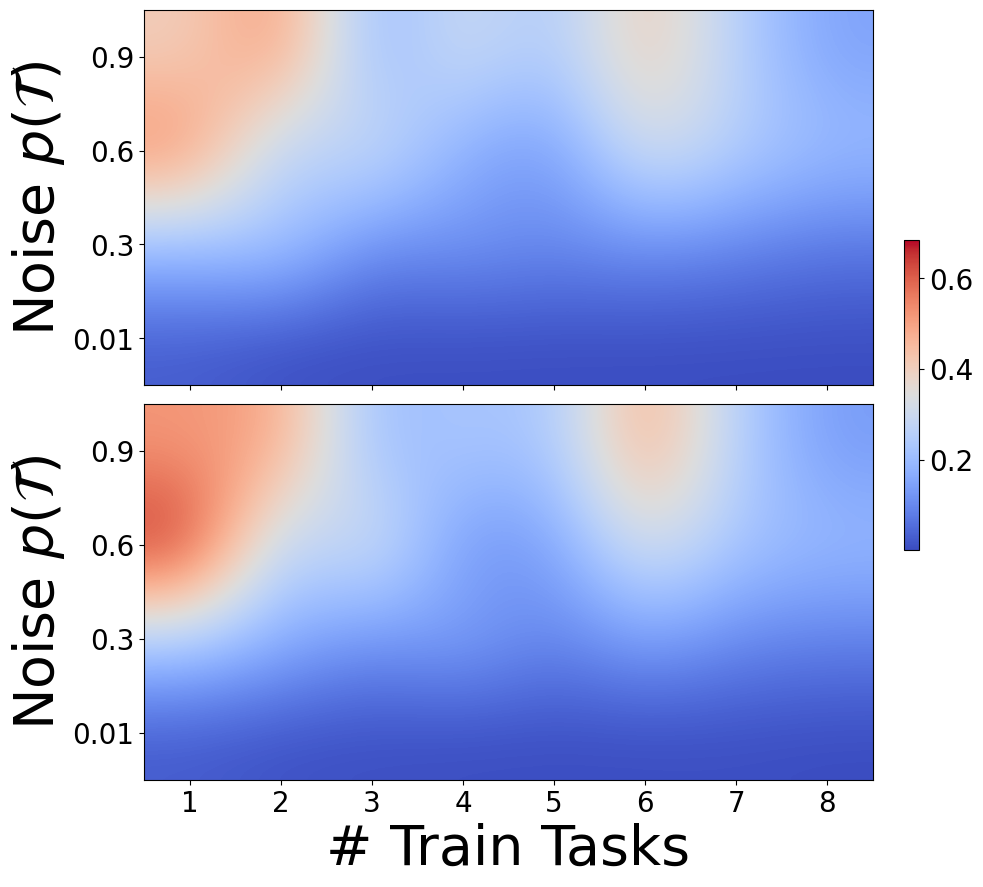

In [284]:
loss_max_matrix = np.zeros((len(SIGMA_NOISES), len(N_TASK_VALUES)))
loss_min_matrix = np.zeros((len(SIGMA_NOISES), len(N_TASK_VALUES)))

for (n_tasks, sigma_noise, loss) in all_losses_max:
    i = SIGMA_NOISES.index(sigma_noise)
    j = N_TASK_VALUES.index(n_tasks)
    loss_max_matrix[i, j] = loss

for (n_tasks, sigma_noise, loss) in all_losses_min:
    i = SIGMA_NOISES.index(sigma_noise)
    j = N_TASK_VALUES.index(n_tasks)
    loss_min_matrix[i, j] = loss

# Plotting with shared colorbar
fig, axes = plt.subplots(
    nrows=2,
    sharex=True,
    figsize=(FIG_HEIGHT, FIG_HEIGHT),
    gridspec_kw={"height_ratios": [1, 1], "hspace": 0.05}  # Smaller hspace
)

cmap = 'coolwarm'
vmin = min(loss_max_matrix.min(), loss_min_matrix.min())
vmax = max(loss_max_matrix.max(), loss_min_matrix.max())

# Heatmaps
im1 = axes[0].imshow(loss_max_matrix, aspect='auto', cmap=cmap, origin='lower', vmin=vmin, vmax=vmax,
                         interpolation='bicubic'  # Try 'bilinear' or 'gaussian' too
                     )
axes[0].set_ylabel('Noise $p(\mathcal{T})$', fontsize=2*LABEL_FONT_SIZE)
axes[0].set_yticks(np.arange(len(SIGMA_NOISES)))
axes[0].set_yticklabels(SIGMA_NOISES, fontsize=LABEL_FONT_SIZE)

im2 = axes[1].imshow(loss_min_matrix, aspect='auto', cmap=cmap, origin='lower', vmin=vmin, vmax=vmax,
                                              interpolation='bicubic'  # Try 'bilinear' or 'gaussian' too
                     )
axes[1].set_xlabel('# Train Tasks', fontsize=2*LABEL_FONT_SIZE)
axes[1].set_ylabel('Noise $p(\mathcal{T})$', fontsize=2*LABEL_FONT_SIZE)
axes[1].set_yticks(np.arange(len(SIGMA_NOISES)))
axes[1].set_yticklabels(SIGMA_NOISES, fontsize=LABEL_FONT_SIZE)
axes[1].set_xticks(np.arange(len(N_TASK_VALUES)))
axes[1].set_xticklabels(N_TASK_VALUES, fontsize=LABEL_FONT_SIZE)

# Shared colorbar
cbar = fig.colorbar(im2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.ax.tick_params(labelsize=LABEL_FONT_SIZE)

plt.tight_layout()
plt.show()

## Step 3: Learn a Hereditary-Symmetry

- Let $W$ be the differential generator of the Meta-Geometry (acting on $S \times A$)
- Ideally, we want that $G^W$ is also a symmetry of the base-MDP (task 0 for now). Then, we could train in task $0$ and generalize to new tasks to equivariance.
- How can we check whether $G^W$ is a symmetry of the base-MDP?
    - Functional Level: It is a symmetry if each orbit stays within each level set.
    - Differential Level: The Lie-Bracket between $W$ and $D^1$ is closed, e.g. $[V_1,V_2] \in D^1 \forall V_1 \in W, V_2 \in D^1$
    - Which we can (once again) check with the orthogonal complement

In [82]:
CENTER_KERNEL = TASK_GOALS[0] #SO(2) rotation is not a symmetry of this
# CENTER_KERNEL=th.tensor([0,0], dtype=DTYPE) # SO(2) rotation is a symmetry of this

def vector_field_task_1(p: th.tensor)->th.tensor:
    """Returns a kernel sample at a single point p from the base task."""
    _generator=th.tensor([[0, -1], [1,0]], dtype=DTYPE, requires_grad=False)
    projected_state = (p-CENTER_KERNEL)
    return th.matmul(_generator, projected_state)

In [100]:
# Callables for the vector fields of the base task and the generator of the symmetry that take in a point p and
# return the vector field evaluated at that point
META_SYMMETRY_LEARNED=th.tensor([[0, -0.5], [0.5,0]], dtype=DTYPE)
base_task_vf_1_callable=lambda p : vector_field_task_1(p) 
generator_vf_1_callable=lambda p : th.matmul(META_SYMMETRY_LEARNED, p)
base_task_vf_1_callable_batched=th.vmap(base_task_vf_1_callable)
generator_vf_1_callable_batched=th.vmap(generator_vf_1_callable)

BATCH_SIZE_BRACKET=128
ps=th.randn(size=(BATCH_SIZE_BRACKET,STATE_DIM), dtype=DTYPE)

# If generator W is a symmetry of $f$, the infinitesimal generator must again be inside the Kernel.
# E.g., the bracket at p must be inside the span of the Kernel at p.
def project_onto_subspace(vecs: th.tensor, basis: th.tensor) -> Tuple[th.tensor, th.tensor]:
    """Decomposes batch-wise a vector into a projection (projec) and an orthogonal complement (ortho_comp) with respect to a vector space spanned by a basis.
    We have vecs=projec + ortho_comp, projec \in span(basis), ortho_comp \ni span(basis)
    Args:
    vecs: tensor of shape (b,n)
    basis: tensor of shape (b,d,n)

    Returns:
    projec: tensor of shape (b,n), the projection of each vector into the vector space spanned by basis
    ortho_comp: tensor of shape (b,n), the orthogonal complement of each vector relative to the vector space spanned by basis
    """
    basis_t = basis.transpose(1, 2)  #(b,n,d)
    
    # Compute Gram matrix and its pseudo-inverse: (b,d,d)
    G = th.matmul(basis, basis_t)  # (b,d,d)
    G_inv = th.linalg.pinv(G)

    # Compute projection matrix: (b,n,n)
    P = th.matmul(basis_t, th.matmul(G_inv, basis))  # (b,n,n)
    
    # Project vecs: (b,d,n)
    vecs_b=vecs.unsqueeze(1)
    projec=th.matmul(vecs_b, P)  # (b,1,n)
    ortho_comp=vecs_b-projec
    return projec.squeeze(1), ortho_comp.squeeze(1)

# # Get the frame of the Kernel distribution of the first task at each sampled point.
ps_kernel_bases=base_task_vf_1_callable_batched(ps)
# WARNING: This is currently in the 1-D case. So we squeeze in an extra dimension.
ps_kernel_bases=ps_kernel_bases.unsqueeze(1)
ps_generator=generator_vf_1_callable_batched(ps)
assert len(ps_kernel_bases.shape)==3, "Shape should be (batch_size, kernel_dimension, ambient_dimension)"
_, ps_gen_ortho_comp_kernel=project_onto_subspace(ps_generator, basis=ps_kernel_bases)

ortho_comp_mean_norm=th.norm(ps_gen_ortho_comp_kernel, dim=1).mean()
print(f"""Is W a symmetry of Kernel? Yes if and only if norm of orthogonal complement of generator with respect to Kernel is zero.\n
      Is Norm of Orthogonal Complement Zero? {th.allclose(ortho_comp_mean_norm, th.tensor(0.0, dtype=DTYPE), atol=0.01)}
      Orthogonal complement (mean across sampled points): {ortho_comp_mean_norm.round(decimals=2)}
      Current Center of Kernel (Symmetry if center is origin): {CENTER_KERNEL}""")

Is W a symmetry of Kernel? Yes if and only if norm of orthogonal complement of generator with respect to Kernel is zero.

      Is Norm of Orthogonal Complement Zero? False
      Orthogonal complement (mean across sampled points): 0.27000001072883606
      Current Center of Kernel (Symmetry if center is origin): tensor([1., 0.])


## Can only visualize The two vector fields

In [90]:
def push_forward_vector_field(ps: th.tensor,
                              H_func: callable,
                              vf_1_vec: callable,
                              vf_2_vec: Optional[Callable] = None) -> Tuple[th.Tensor, Optional[th.Tensor]]:    
    """Push forward of a vector field vf_1_vec via a diffeomorphism H_vec evaluated at points ps.
    Args
    Returns:
    - dH_p_vf_1_p, th.tensor of shape (b, n), push-forward of vector field vf_1 under H evaluated at p
    - vf_2_vec, th.tensor of shape (b,n) or None, vector field vf_2 evaluated at H(p)
    """
    H_func_vec=th.vmap(H_func)
    H_ps = H_func_vec(ps).detach()

    #VF_2_H(p)
    if vf_2_vec is not None:
        vf_2_H_p=vf_2_vec(H_ps)
    else:
        vf_2_H_p=None

    # dF_p(X_p)
    dH_p=compute_vec_jacobian(H_func, ps)
    vf_1_p=vf_1_vec(ps).unsqueeze(-1) #add trailing dimension for batch multiplication.
    dH_p_vf_1_p = th.bmm(dH_p, vf_1_p).squeeze(-1) #TODO, is this BMM correct? #shape (batch_size, ambient dim)
    return dH_p_vf_1_p, vf_2_H_p

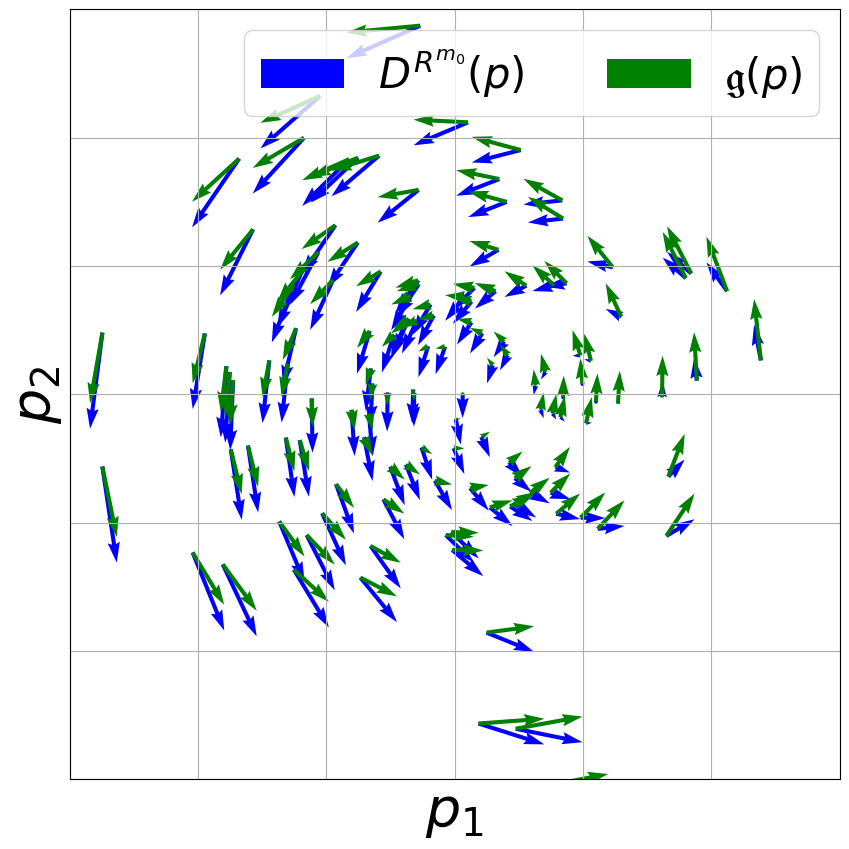

In [171]:
H_identity_tensor=th.tensor([[1,0,0], [0,1,0]], dtype=DTYPE)
H_learned_func=lambda p: th.matmul(H_identity_tensor.detach(), th.cat([p, th.tensor([1.0], dtype=DTYPE)]))[:STATE_DIM] #discard bias term

kernel_samples, generator_samples=push_forward_vector_field(ps=ps,
                                                               H_func=H_learned_func,
                                                               vf_1_vec=base_task_vf_1_callable_batched,
                                                               vf_2_vec=generator_vf_1_callable_batched
                                                               )

import matplotlib.pyplot as plt
plt.figure(figsize=(FIG_HEIGHT, FIG_HEIGHT))
plt.quiver(ps[:,0], ps[:,1], kernel_samples[:,0], kernel_samples[:,1], angles='xy', scale_units='xy', scale=5, color='blue', label="$D^{R^{m_0}}(p)$")
plt.quiver(ps[:,0], ps[:,1], generator_samples[:,0], generator_samples[:,1], angles='xy', scale_units='xy', scale=2.5, color='green', label="$\mathfrak{g}(p)$")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel("$p_1$", fontsize=2*LABEL_FONT_SIZE)
plt.ylabel("$p_2$", fontsize=2*LABEL_FONT_SIZE)
plt.gca().set_aspect('equal')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.legend(ncols=3, fontsize=1.5*LABEL_FONT_SIZE)
plt.grid()

## Learn diffeomorphism $H$ acting on $S \times A$ from task 0 to base MDP such that SO(2) becomes a symmetry, e.g. SO(2) stays inside the Kernel of task 0. 
Then, both vector fields will once again be F-related.
- Call the Kernel vector field of task 0 X and the Generator vector field Y
- Then, we have that dF_p(X_p)=Y_F(p)
- E.g. we evaluate the Generator at the transformed points and the Kernel at the original points but left-multiply the derivative of F at p to the Kernel.

### First use Oracle transformation to motivate approach.

In [84]:
# Ground-truth transformation that shifts all data one unit to the left, e.g. the base task into the origin
# We apply H_star to our data and then discard the bias term again afterwards
H_STAR=th.tensor([[1.0,0.0,-1.0], [0.0, 1.0, 0.0]], dtype=DTYPE, requires_grad=True)
H_star_func=lambda p: th.matmul(H_STAR, th.cat([p, th.tensor([1.0], dtype=DTYPE)]))
H_star_func_vec=th.vmap(H_star_func)

In [85]:
ps_test =th.randn(size=(500,STATE_DIM), dtype=DTYPE)
ps_test_tilde = H_star_func_vec(ps_test).detach()
# dF_p(X_p)
ps_kernel_bases_flat=base_task_vf_1_callable_batched(ps_test)
ps_kernel_bases=ps_kernel_bases_flat.unsqueeze(1)
# Y_F(p)
# Here, dF is the identity matrix so we can drop it but in general we must differentiate F.
ps_generator_flat=generator_vf_1_callable_batched(ps_test_tilde)

In [86]:
assert len(ps_kernel_bases.shape)==3, f"Shape should be (batch_size, kernel_dimension, ambient_dimension). Current shape: {ps_kernel_bases_flat.shape}"
_, ps_gen_ortho_comp_kernel=project_onto_subspace(ps_generator_flat, basis=ps_kernel_bases)

ortho_comp_mean_norm=th.norm(ps_gen_ortho_comp_kernel, dim=1).mean()
print(f"""Is W a symmetry of F-related Kernel? Yes if and only if norm of orthogonal complement of generator with respect to Kernel is zero.\n
      Is Norm of Orthogonal Complement Zero? {th.allclose(ortho_comp_mean_norm, th.tensor(0.0, dtype=DTYPE), atol=0.01)}
      Orthogonal complement (mean across sampled points): {ortho_comp_mean_norm.round(decimals=2)}""")

Is W a symmetry of F-related Kernel? Yes if and only if norm of orthogonal complement of generator with respect to Kernel is zero.

      Is Norm of Orthogonal Complement Zero? True
      Orthogonal complement (mean across sampled points): 0.0


## Both vector fields are the same (also at the right points)

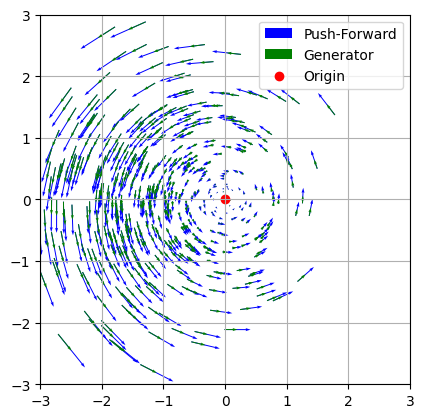

In [88]:
import matplotlib.pyplot as plt
plt.quiver(ps_test_tilde[:,0], ps_test_tilde[:,1], ps_kernel_bases_flat[:,0], ps_kernel_bases_flat[:,1], angles='xy', scale_units='xy', scale=5, color='blue', label="$H_*$")
plt.quiver(ps_test_tilde[:,0], ps_test_tilde[:,1], ps_generator_flat[:,0], ps_generator_flat[:,1], angles='xy', scale_units='xy', scale=5, color='green', label="Generator")
plt.scatter(0,0, label="Origin", color="red")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.gca().set_aspect('equal')
plt.legend()
plt.grid()

## Learn the Translation Map F

In [141]:
# Diffeomorphism, in our case the space of all affine maps.
H_0=th.tensor(th.randn(size=(STATE_DIM, STATE_DIM+1)), dtype=DTYPE, requires_grad=True)

def learn_translation_map(H_0:th.tensor,
                         vf_1_vec: callable,
                         vf_2_vec: callable,
                         coeff_l1_regu: float=0.05,
                         batch_size:int=1028,
                         n_iter:int=20_000,
                         track_Hs:bool=False
                         )->th.tensor:
    """
    Learns an F-relation between two vector fields. If the relation exists, H_*vf_1 is the push-forward vf_1 and we have H_*vf_1=vf_2

    Args:
    - H_0: th.tensor of shape (STATE_DIM+1,STATE_DIM+1), initialization of the F-relation. Currently only supports affine maps (hence the +1 for the bias term).
    - vf_1_vec: Vectorized callable that returns the tangent vector of vector field vf_1 at a batch of points.
    - vf_2_vec: Vectorized callable that returns the tangent vector of vector field vf_2 at a batch of points.
    - coeff_l1_regu: float, coefficient for the L-1 regularizer to enforce a sparse $H$.
    - track_Hs: bool, whether to track how the Hs transform during the optimization.

    Returns:
    The learned F-relation (if it exists).
    """

    warnings.warn("Learning affine transformation only.")
    warnings.warn("Only implemented for one-dimensional Kernel distributions.")
    pbar = tqdm(range(n_iter), desc="Compute Meta-Symmetry")
    Hs_over_time=[]

    H=th.tensor(H_0.clone(), dtype=DTYPE, requires_grad=True)
    H_func=lambda p: th.matmul(H, th.cat([p, th.tensor([1.0], dtype=DTYPE)]))
    opt_H=th.optim.Adam([H], lr=0.00035)


    for idx_step in pbar:

        H_func_vec=th.vmap(H_func)

        # Sample batch of points
        ps =th.randn(size=(batch_size,STATE_DIM), dtype=DTYPE)
        H_ps = H_func_vec(ps)

        # VF2_F(p)
        vf_2_H_ps=vf_2_vec(H_ps)
        
        # dH_p(VF1_p)
        dH_p=compute_vec_jacobian(H_func, ps)
        vf_1_p=vf_1_vec(ps).unsqueeze(-1) #add trailing dimension for batch multiplication.
        dH_p_vf_1_p = th.bmm(dH_p, vf_1_p).squeeze(-1) #TODO, is this BMM correct? #shape (batch_size, ambient dim)

        # Add extra dimension as Kernel is one-dimensional.
        kernel_tilde_basis=dH_p_vf_1_p.unsqueeze(1)                

        # Project Generator into Transform of Kernel
        assert len(kernel_tilde_basis.shape)==3, f"Shape should be (batch_size, kernel_dimension, ambient_dimension). Current shape: {ps_kernel_bases_flat.shape}"
        _, ps_gen_ortho_comp_kernel=project_onto_subspace(vf_2_H_ps, basis=kernel_tilde_basis)
        loss_span=th.norm(ps_gen_ortho_comp_kernel, dim=1).mean(dim=0)
        loss_reg=coeff_l1_regu*th.norm(H, p=1)
        loss=loss_span+loss_reg

        # Take gradient step
        opt_H.zero_grad()
        loss.backward()
        opt_H.step()
        if idx_step % 100 == 0:
            pbar.set_postfix({'Diffeomorphism. Loss (optimum=0)': f'{loss:.2f}',
                              'Ratio Span Loss and L-1 Regularizer Loss:': f'{loss_span/loss_reg:.2f}'})
            if track_Hs:
                Hs_over_time.append(H.detach().round(decimals=3))
    return H.round(decimals=3), Hs_over_time

H_star_learned, H_star_over_time = learn_translation_map(H_0=H_0,
                      vf_1_vec=base_task_vf_1_callable_batched,
                      vf_2_vec=generator_vf_1_callable_batched,
                      coeff_l1_regu=0.1,
                      n_iter=5000,
                      track_Hs=True)

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_39946/1366276723.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H_0=th.tensor(th.randn(size=(STATE_DIM, STATE_DIM+1)), dtype=DTYPE, requires_grad=True)
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_39946/1366276723.py:26: UserWarning: Learning affine transformation only.
  warnings.warn("Learning affine transformation only.")
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_39946/1366276723.py:27: UserWarning: Only implemented for one-dimensional Kernel distributions.
  warnings.warn("Only implemented for one-dimensional Kernel distributions.")
Compute Meta-Symmetry:   0%|          | 0/5000 [00:00<?, ?it/s]/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_39946/1366276723.py:31: UserWarning: To copy construct from a tensor, it is recommended 

In [177]:
# Convert learned generator into callable and vectorize.
H_learned_func=lambda p: th.matmul(H_star_learned.detach(), th.cat([p, th.tensor([1.0], dtype=DTYPE)]))[:STATE_DIM] #discard bias term
H_learned_func_vec=th.vmap(H_learned_func)

# Sample some points and project.
ps_vis=th.randn(size=(100, STATE_DIM), dtype=DTYPE)
H_ps_vis=H_learned_func_vec(ps_vis)

push_forward_kernel, generator_tilde=push_forward_vector_field(ps=ps_vis,
                                                               H_func=H_learned_func,
                                                               vf_1_vec=base_task_vf_1_callable_batched,
                                                               vf_2_vec=generator_vf_1_callable_batched
                                                               )

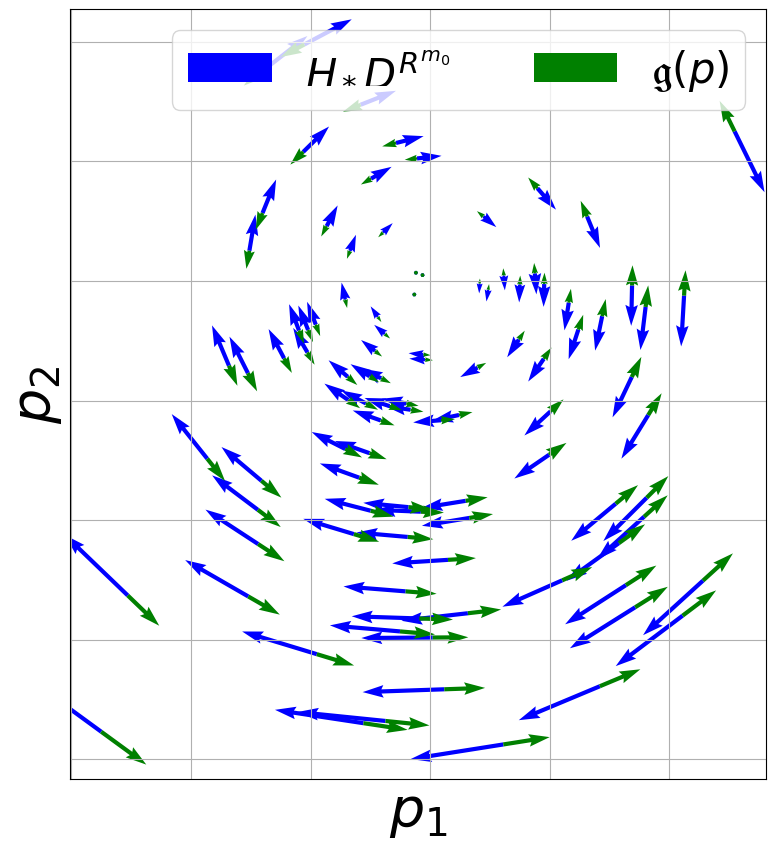

In [181]:
import matplotlib.pyplot as plt
plt.figure(figsize=(FIG_HEIGHT, FIG_HEIGHT))
plt.quiver(H_ps_vis[:,0], H_ps_vis[:,1], push_forward_kernel[:,0], push_forward_kernel[:,1], angles='xy', scale_units='xy', scale=5, color='blue', label="$H_*D^{R^{m_0}}$")
plt.quiver(H_ps_vis[:,0], H_ps_vis[:,1], generator_tilde[:,0], generator_tilde[:,1], angles='xy', scale_units='xy', scale=5, color='green', label="$\mathfrak{g}(p)$")
plt.xlabel("$p_1$", fontsize=2*LABEL_FONT_SIZE)
plt.ylabel("$p_2$", fontsize=2*LABEL_FONT_SIZE)
plt.gca().set_aspect('equal')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.legend(ncols=3, fontsize=1.5*LABEL_FONT_SIZE)
plt.grid()

## Plot how push-forward changes over time

In [40]:
ps_vis=th.randn(size=(100, STATE_DIM), dtype=DTYPE)
push_forward_over_time=[]
generator_tilde_over_time=[]
H_ps_vis_over_time=[]

for learned_H in H_star_over_time:
    
    # Convert learned generator into callable and vectorize.
    H_learned_func=lambda p: th.matmul(learned_H.detach(), th.cat([p, th.tensor([1.0], dtype=DTYPE)]))[:STATE_DIM] #discard bias term
    H_learned_func_vec=th.vmap(H_learned_func)

    # Sample some points and project.
    H_ps_vis=H_learned_func_vec(ps_vis)

    push_forward_kernel, generator_tilde=push_forward_vector_field(ps=ps_vis,
                                                                H_func=H_learned_func,
                                                                vf_1_vec=base_task_vf_1_callable_batched,
                                                                vf_2_vec=generator_vf_1_callable_batched
                                                                )
    push_forward_over_time.append(push_forward_kernel)
    generator_tilde_over_time.append(generator_tilde)
    H_ps_vis_over_time.append(H_ps_vis)

/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_39946/1156638937.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_kernel = get_cmap('cividis')
/var/folders/cm/rfx_nb1x16zcxk4frrwkp_1r0000gn/T/ipykernel_39946/1156638937.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_generator = get_cmap('coolwarm')


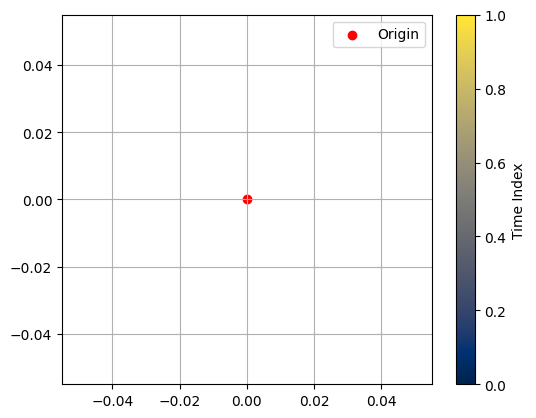

In [125]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
cmap_kernel = get_cmap('cividis')
cmap_generator = get_cmap('coolwarm')
n_Hs = len(H_star_over_time)

fig, ax = plt.subplots()
ax.grid()
for idx, (H_ps_vis, push_forward_kernel, generator_tilde) in enumerate(zip(push_forward_over_time, generator_tilde_over_time, H_ps_vis_over_time)):
    if idx==99:
        color_kernel = cmap_kernel(idx / (n_Hs - 1))
        color_generator = cmap_generator(idx / (n_Hs - 1))

        # Normalize all vectors to unit length.
        push_fwd_norm=th.norm(push_forward_kernel, dim=1, keepdim=True)
        generator_norm=th.norm(generator_tilde, dim=1, keepdim=True)
        push_fwd_normalized=push_forward_kernel/push_fwd_norm
        generator_normalized=generator_tilde/generator_norm

        ax.quiver(H_ps_vis[:,0], H_ps_vis[:,1], push_fwd_normalized[:,0], push_fwd_normalized[:,1], angles='xy', scale_units='xy', scale=2, color=color_kernel)
        ax.quiver(H_ps_vis[:,0], H_ps_vis[:,1], generator_normalized[:,0], generator_normalized[:,1], angles='xy', scale_units='xy', scale=2, color=color_generator)
sm = plt.cm.ScalarMappable(cmap=cmap_kernel)
sm.set_array([])  # Required for colorbar
fig.colorbar(sm, ax=ax, label='Time Index')
ax.scatter(0,0, label="Origin", color="red")
# ax.set_xlim(-5, 5)
# ax.set_ylim(-5, 5)
ax.set_aspect('equal')
ax.legend()

## Visualize Coordinate System we Learned

In [144]:
print("Learned Change of Basis:\n", H_star_learned)
print("Learned Coordinate System looks like a 2-D rotation matrix + plus one-unit shift up")

Learned Change of Basis:
 tensor([[ 0.0000,  0.1190,  0.0000],
        [ 0.1190,  0.0000, -0.1190]], grad_fn=<RoundBackward1>)
Learned Coordinate System looks like a 2-D rotation matrix + plus one-unit shift up


## Decompose H_star_learned into 3 transformations to show effect.

In [175]:
H_star_learned_func=lambda p: th.matmul(H_star_learned.detach(), th.cat([p, th.tensor([1.0], dtype=DTYPE)]))[:STATE_DIM] #discard bias term
H_star_learned_func_vec=th.vmap(H_star_learned_func)

In [209]:
import numpy as np
import torch as th
import matplotlib.pyplot as plt

# Settings
DTYPE = th.float32
N_SAMPLES = 5

# Create base 2D grid
def create_grid(n_samples=5, range_lim=2.0):
    x = np.linspace(-range_lim, range_lim, n_samples)
    y = np.linspace(-range_lim, range_lim, n_samples)
    X, Y = np.meshgrid(x, y)
    grid_np = np.stack([X, Y], axis=-1)
    return grid_np

# Plotting function for one subplot
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_transformation(ax, original_grid, transformed_grid, idx_plot):
    for i in range(N_SAMPLES):
        ax.plot(transformed_grid[i,:,0], transformed_grid[i,:,1], color='gray', linewidth=2)
        ax.plot(transformed_grid[:,i,0], transformed_grid[:,i,1], color='gray', linewidth=2)
    ax.quiver(original_grid[...,0], original_grid[...,1],
              (transformed_grid[...,0] - original_grid[...,0]),
              (transformed_grid[...,1] - original_grid[...,1]),
              angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.6)
    ax.set_aspect('equal')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

    # Only show x-labels on bottom row
    if idx_plot // 2 == 1:
        ax.set_xlabel("$p_1$", fontsize=2*LABEL_FONT_SIZE)
        ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    else:
        ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

    # Only show y-labels on left column
    if idx_plot % 2 == 0:
        ax.set_ylabel("$p_2$", fontsize=2*LABEL_FONT_SIZE)
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    else:
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)


# Main visualization function
def visualize_transform_sequence(transform_funcs):
    assert len(transform_funcs) == 4, "Provide exactly four transformation functions"

    grid_np = create_grid(N_SAMPLES)
    grid_torch = th.tensor(grid_np.reshape(-1, 2), dtype=DTYPE)

    # Prepare 2x2 plots with shared x and y axes
    fig, axes = plt.subplots(2, 2, figsize=(FIG_HEIGHT, FIG_HEIGHT), sharex=True, sharey=True)

    current_grid_np = grid_np
    current_grid_torch = grid_torch

    for idx, func in enumerate(transform_funcs):
        transformed_flat = func(current_grid_torch)
        transformed_np = transformed_flat.reshape(N_SAMPLES, N_SAMPLES, 2).detach().numpy()

        ax = axes[idx // 2, idx % 2]
        plot_transformation(ax, current_grid_np, transformed_np, idx_plot=idx)

        # Update for next step
        current_grid_np = transformed_np
        current_grid_torch = th.tensor(transformed_np.reshape(-1, 2), dtype=DTYPE)

    plt.tight_layout()
    plt.show()



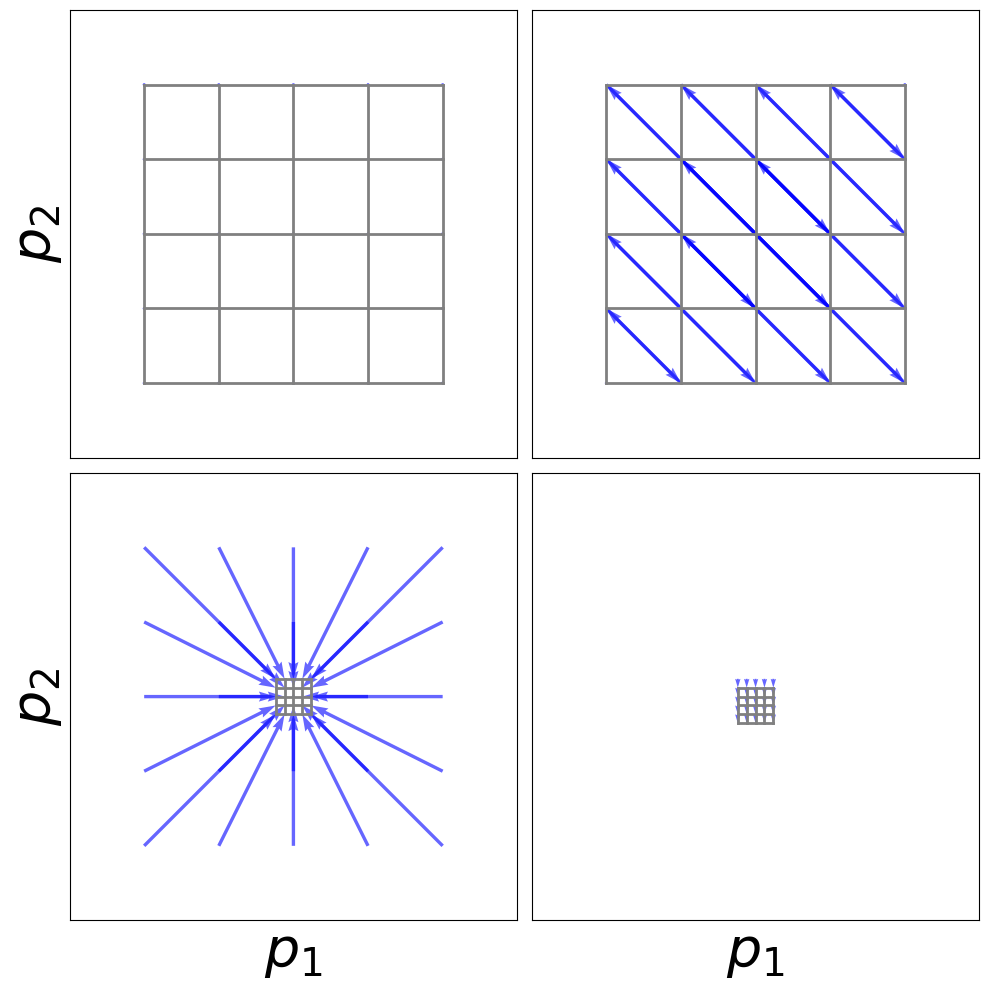

In [210]:
# Define your transformation functions (each maps a tensor of shape (N, 2) → (N, 2))
identity = lambda x: x
swap_xy = lambda x: x[:, [1, 0]]
scale_0_119 = lambda x: x * 0.119
shift_y = lambda x: x + th.tensor([0.0, -0.119], dtype=DTYPE)

# Visualize them
visualize_transform_sequence([identity, swap_xy, scale_0_119, shift_y])
